In [8]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [9]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [10]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [11]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [12]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [13]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    ################################################ s', r = env(s, a)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    next_states_logits, Qlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                      action_size=action_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, nextQlogits = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                          action_size=action_size, state_size=state_size, reuse=True)
    #################################################### GAN
    Qlogits = tf.reshape(Qlogits, shape=[-1])
    nextQlogits = tf.reshape(nextQlogits, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qlogits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(nextQlogits) # minimize nextQ
    aloss = -tf.reduce_mean(nextQlogits) # maximize nextQ
    ###################################################### Qlearning
    ###################################################### Q(s,a)= r + Q'(s',a')
    rewards = tf.reduce_mean(tf.square(Qlogits - (gamma * nextQlogits)))
    ##################################################### GAN + DDPG
    eloss += tf.reduce_mean(rewards) # minimize entropy=error
    aloss += -tf.reduce_mean(rewards) # maximize entropy=rewards
    return actions_logits, aloss, eloss, rewards

In [14]:
def model_opt(a_loss, e_loss, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
    return a_opt, e_opt

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.rewards_ = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt = model_opt(a_loss=self.a_loss, e_loss=self.e_loss,
                                           a_learning_rate=a_learning_rate,
                                           e_learning_rate=e_learning_rate)

In [16]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [18]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [19]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [20]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [23]:
def minibacth_random(memory, batch_size):
    # Training with the maxrated minibatch
    while True:
        batch = memory.sample(batch_size=batch_size)
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        next_states = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        dones = np.array([each[4] for each in batch])
        rates = np.array([each[5] for each in batch])
        states = states[rates > 0]
        actions = actions[rates > 0]
        next_states = next_states[rates > 0]
        rewards = rewards[rates > 0]
        dones = dones[rates > 0]
        rates = rates[rates > 0]
        if len(dones) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [24]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth_random(memory=memory, 
                                                                                   batch_size=batch_size)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss_batch.append(eloss)
            aloss_batch.append(aloss)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 aloss:-0.0894 eloss:3.5387 exploreP:0.9979
Episode:1 meanR:18.0000 R:15.0000 rate:0.0300 aloss:-0.0844 eloss:3.5306 exploreP:0.9964
Episode:2 meanR:17.6667 R:17.0000 rate:0.0340 aloss:-0.0783 eloss:3.5196 exploreP:0.9948
Episode:3 meanR:18.7500 R:22.0000 rate:0.0440 aloss:-0.0717 eloss:3.5083 exploreP:0.9926
Episode:4 meanR:18.0000 R:15.0000 rate:0.0300 aloss:-0.0675 eloss:3.5016 exploreP:0.9911
Episode:5 meanR:19.6667 R:28.0000 rate:0.0560 aloss:-0.0561 eloss:3.4850 exploreP:0.9884
Episode:6 meanR:20.0000 R:22.0000 rate:0.0440 aloss:-0.0446 eloss:3.4694 exploreP:0.9862
Episode:7 meanR:19.0000 R:12.0000 rate:0.0240 aloss:-0.0368 eloss:3.4584 exploreP:0.9851
Episode:8 meanR:18.6667 R:16.0000 rate:0.0320 aloss:-0.0270 eloss:3.4454 exploreP:0.9835
Episode:9 meanR:18.2000 R:14.0000 rate:0.0280 aloss:-0.0222 eloss:3.4387 exploreP:0.9821
Episode:10 meanR:19.0000 R:27.0000 rate:0.0540 aloss:-0.0086 eloss:3.4223 exploreP:0.9795
Episode:11 meanR:22.

Episode:93 meanR:21.8085 R:23.0000 rate:0.0460 aloss:1.3624 eloss:1.8902 exploreP:0.8165
Episode:94 meanR:21.9053 R:31.0000 rate:0.0620 aloss:1.3832 eloss:1.8684 exploreP:0.8140
Episode:95 meanR:21.9167 R:23.0000 rate:0.0460 aloss:1.3991 eloss:1.8539 exploreP:0.8122
Episode:96 meanR:21.9381 R:24.0000 rate:0.0480 aloss:1.4382 eloss:1.8136 exploreP:0.8102
Episode:97 meanR:22.0408 R:32.0000 rate:0.0640 aloss:1.4392 eloss:1.8126 exploreP:0.8077
Episode:98 meanR:21.9495 R:13.0000 rate:0.0260 aloss:1.4525 eloss:1.8005 exploreP:0.8066
Episode:99 meanR:22.0100 R:28.0000 rate:0.0560 aloss:1.4553 eloss:1.7988 exploreP:0.8044
Episode:100 meanR:22.1500 R:35.0000 rate:0.0700 aloss:1.4737 eloss:1.7817 exploreP:0.8016
Episode:101 meanR:22.5300 R:53.0000 rate:0.1060 aloss:1.5100 eloss:1.7469 exploreP:0.7975
Episode:102 meanR:22.4900 R:13.0000 rate:0.0260 aloss:1.5042 eloss:1.7556 exploreP:0.7964
Episode:103 meanR:22.8800 R:61.0000 rate:0.1220 aloss:1.5399 eloss:1.7171 exploreP:0.7916
Episode:104 meanR

Episode:185 meanR:25.3800 R:11.0000 rate:0.0220 aloss:3.1693 eloss:0.2400 exploreP:0.6445
Episode:186 meanR:25.3900 R:19.0000 rate:0.0380 aloss:3.2170 eloss:0.1924 exploreP:0.6433
Episode:187 meanR:25.4800 R:18.0000 rate:0.0360 aloss:3.1919 eloss:0.2171 exploreP:0.6421
Episode:188 meanR:25.3800 R:10.0000 rate:0.0200 aloss:3.1995 eloss:0.2109 exploreP:0.6415
Episode:189 meanR:25.3300 R:18.0000 rate:0.0360 aloss:3.1930 eloss:0.2211 exploreP:0.6404
Episode:190 meanR:25.3100 R:11.0000 rate:0.0220 aloss:3.2723 eloss:0.1392 exploreP:0.6397
Episode:191 meanR:25.2100 R:10.0000 rate:0.0200 aloss:3.2783 eloss:0.1340 exploreP:0.6390
Episode:192 meanR:25.2300 R:15.0000 rate:0.0300 aloss:3.2615 eloss:0.1536 exploreP:0.6381
Episode:193 meanR:25.1200 R:12.0000 rate:0.0240 aloss:3.2906 eloss:0.1232 exploreP:0.6374
Episode:194 meanR:25.0000 R:19.0000 rate:0.0380 aloss:3.2606 eloss:0.1517 exploreP:0.6362
Episode:195 meanR:24.8800 R:11.0000 rate:0.0220 aloss:3.3027 eloss:0.1172 exploreP:0.6355
Episode:19

Episode:276 meanR:28.6100 R:49.0000 rate:0.0980 aloss:5.0335 eloss:-1.3156 exploreP:0.5044
Episode:277 meanR:28.6600 R:48.0000 rate:0.0960 aloss:5.1277 eloss:-1.4064 exploreP:0.5020
Episode:278 meanR:28.2400 R:27.0000 rate:0.0540 aloss:5.1047 eloss:-1.3804 exploreP:0.5007
Episode:279 meanR:28.7800 R:75.0000 rate:0.1500 aloss:5.1750 eloss:-1.4488 exploreP:0.4970
Episode:280 meanR:28.6500 R:8.0000 rate:0.0160 aloss:5.1076 eloss:-1.3759 exploreP:0.4966
Episode:281 meanR:28.2200 R:24.0000 rate:0.0480 aloss:5.0652 eloss:-1.3397 exploreP:0.4955
Episode:282 meanR:28.9500 R:102.0000 rate:0.2040 aloss:5.1933 eloss:-1.4607 exploreP:0.4905
Episode:283 meanR:28.6600 R:67.0000 rate:0.1340 aloss:5.2275 eloss:-1.4856 exploreP:0.4873
Episode:284 meanR:28.9500 R:38.0000 rate:0.0760 aloss:5.3015 eloss:-1.5561 exploreP:0.4855
Episode:285 meanR:29.0600 R:22.0000 rate:0.0440 aloss:5.3482 eloss:-1.5882 exploreP:0.4845
Episode:286 meanR:29.2100 R:34.0000 rate:0.0680 aloss:5.3088 eloss:-1.5504 exploreP:0.4829

Episode:368 meanR:29.0800 R:9.0000 rate:0.0180 aloss:6.1939 eloss:-2.2818 exploreP:0.3886
Episode:369 meanR:28.6200 R:10.0000 rate:0.0200 aloss:6.2345 eloss:-2.3282 exploreP:0.3882
Episode:370 meanR:28.5500 R:14.0000 rate:0.0280 aloss:6.0698 eloss:-2.1576 exploreP:0.3877
Episode:371 meanR:28.4000 R:9.0000 rate:0.0180 aloss:6.2006 eloss:-2.2915 exploreP:0.3873
Episode:372 meanR:28.2900 R:15.0000 rate:0.0300 aloss:6.5721 eloss:-2.6643 exploreP:0.3868
Episode:373 meanR:28.2600 R:12.0000 rate:0.0240 aloss:6.4952 eloss:-2.5787 exploreP:0.3863
Episode:374 meanR:28.2700 R:15.0000 rate:0.0300 aloss:6.1328 eloss:-2.2185 exploreP:0.3857
Episode:375 meanR:28.0900 R:16.0000 rate:0.0320 aloss:6.5083 eloss:-2.5931 exploreP:0.3851
Episode:376 meanR:27.8200 R:22.0000 rate:0.0440 aloss:5.9271 eloss:-2.0115 exploreP:0.3843
Episode:377 meanR:27.5200 R:18.0000 rate:0.0360 aloss:6.1222 eloss:-2.2165 exploreP:0.3836
Episode:378 meanR:27.5200 R:27.0000 rate:0.0540 aloss:6.4759 eloss:-2.5686 exploreP:0.3826
E

Episode:459 meanR:24.7300 R:142.0000 rate:0.2840 aloss:6.2544 eloss:-2.2833 exploreP:0.3089
Episode:460 meanR:25.2300 R:60.0000 rate:0.1200 aloss:5.3563 eloss:-1.3628 exploreP:0.3071
Episode:461 meanR:25.7100 R:57.0000 rate:0.1140 aloss:4.5373 eloss:-0.5304 exploreP:0.3055
Episode:462 meanR:25.8700 R:30.0000 rate:0.0600 aloss:3.5697 eloss:0.4423 exploreP:0.3046
Episode:463 meanR:26.6300 R:88.0000 rate:0.1760 aloss:2.1723 eloss:1.8434 exploreP:0.3020
Episode:464 meanR:26.7900 R:27.0000 rate:0.0540 aloss:0.5057 eloss:3.5045 exploreP:0.3012
Episode:465 meanR:26.9700 R:27.0000 rate:0.0540 aloss:-0.2871 eloss:4.2891 exploreP:0.3004
Episode:466 meanR:26.9500 R:21.0000 rate:0.0420 aloss:-0.7754 eloss:4.7627 exploreP:0.2998
Episode:467 meanR:26.9900 R:18.0000 rate:0.0360 aloss:-1.3249 eloss:5.3125 exploreP:0.2993
Episode:468 meanR:27.0400 R:14.0000 rate:0.0280 aloss:-1.5605 eloss:5.5330 exploreP:0.2989
Episode:469 meanR:27.1600 R:22.0000 rate:0.0440 aloss:-1.6436 eloss:5.6144 exploreP:0.2982
E

Episode:551 meanR:17.3900 R:11.0000 rate:0.0220 aloss:0.0858 eloss:3.5126 exploreP:0.2718
Episode:552 meanR:17.2600 R:11.0000 rate:0.0220 aloss:-0.1926 eloss:3.7769 exploreP:0.2715
Episode:553 meanR:17.2000 R:12.0000 rate:0.0240 aloss:-0.1027 eloss:3.6933 exploreP:0.2712
Episode:554 meanR:17.1100 R:10.0000 rate:0.0200 aloss:-0.2863 eloss:3.8709 exploreP:0.2709
Episode:555 meanR:16.8500 R:13.0000 rate:0.0260 aloss:-0.0798 eloss:3.6656 exploreP:0.2706
Episode:556 meanR:16.5200 R:16.0000 rate:0.0320 aloss:0.0849 eloss:3.5023 exploreP:0.2702
Episode:557 meanR:15.9200 R:10.0000 rate:0.0200 aloss:-0.2333 eloss:3.8078 exploreP:0.2699
Episode:558 meanR:15.5100 R:11.0000 rate:0.0220 aloss:-0.0005 eloss:3.5776 exploreP:0.2696
Episode:559 meanR:14.2100 R:12.0000 rate:0.0240 aloss:-0.2061 eloss:3.7883 exploreP:0.2693
Episode:560 meanR:13.7300 R:12.0000 rate:0.0240 aloss:-0.2814 eloss:3.8598 exploreP:0.2690
Episode:561 meanR:13.3200 R:16.0000 rate:0.0320 aloss:0.0401 eloss:3.5352 exploreP:0.2686
Ep

Episode:643 meanR:11.7200 R:11.0000 rate:0.0220 aloss:2.2832 eloss:1.3038 exploreP:0.2448
Episode:644 meanR:11.7100 R:9.0000 rate:0.0180 aloss:2.4272 eloss:1.1715 exploreP:0.2446
Episode:645 meanR:11.7200 R:12.0000 rate:0.0240 aloss:2.2774 eloss:1.3173 exploreP:0.2443
Episode:646 meanR:11.6700 R:8.0000 rate:0.0160 aloss:2.2167 eloss:1.3732 exploreP:0.2442
Episode:647 meanR:11.6800 R:9.0000 rate:0.0180 aloss:2.4189 eloss:1.1741 exploreP:0.2439
Episode:648 meanR:11.6900 R:11.0000 rate:0.0220 aloss:2.2758 eloss:1.3177 exploreP:0.2437
Episode:649 meanR:11.7000 R:10.0000 rate:0.0200 aloss:2.2853 eloss:1.3019 exploreP:0.2435
Episode:650 meanR:11.7100 R:14.0000 rate:0.0280 aloss:2.3720 eloss:1.2249 exploreP:0.2431
Episode:651 meanR:11.7400 R:14.0000 rate:0.0280 aloss:2.5468 eloss:1.0524 exploreP:0.2428
Episode:652 meanR:11.7400 R:11.0000 rate:0.0220 aloss:2.4488 eloss:1.1507 exploreP:0.2425
Episode:653 meanR:11.7600 R:14.0000 rate:0.0280 aloss:2.5499 eloss:1.0479 exploreP:0.2422
Episode:654 m

Episode:735 meanR:10.3700 R:9.0000 rate:0.0180 aloss:4.2482 eloss:-0.5101 exploreP:0.2235
Episode:736 meanR:10.3800 R:10.0000 rate:0.0200 aloss:4.2382 eloss:-0.4993 exploreP:0.2232
Episode:737 meanR:10.3500 R:9.0000 rate:0.0180 aloss:4.2034 eloss:-0.4561 exploreP:0.2230
Episode:738 meanR:10.3200 R:9.0000 rate:0.0180 aloss:4.2361 eloss:-0.4861 exploreP:0.2229
Episode:739 meanR:10.3100 R:8.0000 rate:0.0160 aloss:4.4135 eloss:-0.6708 exploreP:0.2227
Episode:740 meanR:10.3000 R:10.0000 rate:0.0200 aloss:4.2921 eloss:-0.5374 exploreP:0.2225
Episode:741 meanR:10.3000 R:9.0000 rate:0.0180 aloss:4.4019 eloss:-0.6455 exploreP:0.2223
Episode:742 meanR:10.3200 R:11.0000 rate:0.0220 aloss:4.3680 eloss:-0.6142 exploreP:0.2220
Episode:743 meanR:10.3100 R:10.0000 rate:0.0200 aloss:4.4710 eloss:-0.7099 exploreP:0.2218
Episode:744 meanR:10.3100 R:9.0000 rate:0.0180 aloss:4.3244 eloss:-0.5628 exploreP:0.2216
Episode:745 meanR:10.3000 R:11.0000 rate:0.0220 aloss:4.2789 eloss:-0.5124 exploreP:0.2214
Episo

Episode:827 meanR:10.1100 R:8.0000 rate:0.0160 aloss:5.3477 eloss:-1.3851 exploreP:0.2046
Episode:828 meanR:10.1200 R:12.0000 rate:0.0240 aloss:5.7028 eloss:-1.7372 exploreP:0.2043
Episode:829 meanR:10.0900 R:11.0000 rate:0.0220 aloss:5.6640 eloss:-1.6992 exploreP:0.2041
Episode:830 meanR:10.0700 R:8.0000 rate:0.0160 aloss:5.6574 eloss:-1.6902 exploreP:0.2040
Episode:831 meanR:10.0500 R:10.0000 rate:0.0200 aloss:5.7618 eloss:-1.7803 exploreP:0.2038
Episode:832 meanR:10.0400 R:8.0000 rate:0.0160 aloss:5.4268 eloss:-1.4555 exploreP:0.2036
Episode:833 meanR:10.0400 R:10.0000 rate:0.0200 aloss:5.2676 eloss:-1.2883 exploreP:0.2034
Episode:834 meanR:10.0300 R:9.0000 rate:0.0180 aloss:5.7580 eloss:-1.7841 exploreP:0.2033
Episode:835 meanR:10.0400 R:10.0000 rate:0.0200 aloss:5.6048 eloss:-1.6243 exploreP:0.2031
Episode:836 meanR:10.0400 R:10.0000 rate:0.0200 aloss:5.8639 eloss:-1.8783 exploreP:0.2029
Episode:837 meanR:10.0500 R:10.0000 rate:0.0200 aloss:5.6709 eloss:-1.6879 exploreP:0.2027
Epi

Episode:919 meanR:10.2800 R:10.0000 rate:0.0200 aloss:7.4271 eloss:-3.2725 exploreP:0.1870
Episode:920 meanR:10.2900 R:10.0000 rate:0.0200 aloss:6.9966 eloss:-2.8597 exploreP:0.1868
Episode:921 meanR:10.3200 R:12.0000 rate:0.0240 aloss:7.3306 eloss:-3.1817 exploreP:0.1866
Episode:922 meanR:10.2900 R:8.0000 rate:0.0160 aloss:7.2653 eloss:-3.1251 exploreP:0.1865
Episode:923 meanR:10.2400 R:8.0000 rate:0.0160 aloss:7.3991 eloss:-3.2438 exploreP:0.1863
Episode:924 meanR:10.2300 R:8.0000 rate:0.0160 aloss:7.3887 eloss:-3.2432 exploreP:0.1862
Episode:925 meanR:10.2200 R:8.0000 rate:0.0160 aloss:7.5519 eloss:-3.3955 exploreP:0.1860
Episode:926 meanR:10.2000 R:11.0000 rate:0.0220 aloss:7.7350 eloss:-3.5756 exploreP:0.1858
Episode:927 meanR:10.2200 R:10.0000 rate:0.0200 aloss:7.8008 eloss:-3.6381 exploreP:0.1857
Episode:928 meanR:10.2000 R:10.0000 rate:0.0200 aloss:7.1711 eloss:-3.0042 exploreP:0.1855
Episode:929 meanR:10.2000 R:11.0000 rate:0.0220 aloss:7.1376 eloss:-2.9813 exploreP:0.1853
Epi

Episode:1011 meanR:9.8800 R:8.0000 rate:0.0160 aloss:7.7760 eloss:-3.5084 exploreP:0.1717
Episode:1012 meanR:9.8700 R:11.0000 rate:0.0220 aloss:7.6048 eloss:-3.3467 exploreP:0.1715
Episode:1013 meanR:9.8500 R:8.0000 rate:0.0160 aloss:7.6841 eloss:-3.4457 exploreP:0.1714
Episode:1014 meanR:9.8500 R:9.0000 rate:0.0180 aloss:7.3012 eloss:-3.0599 exploreP:0.1712
Episode:1015 meanR:9.8100 R:9.0000 rate:0.0180 aloss:7.4892 eloss:-3.2342 exploreP:0.1711
Episode:1016 meanR:9.7900 R:10.0000 rate:0.0200 aloss:7.6442 eloss:-3.3997 exploreP:0.1709
Episode:1017 meanR:9.8000 R:10.0000 rate:0.0200 aloss:7.8338 eloss:-3.5823 exploreP:0.1708
Episode:1018 meanR:9.8600 R:15.0000 rate:0.0300 aloss:7.7100 eloss:-3.4596 exploreP:0.1705
Episode:1019 meanR:9.8600 R:10.0000 rate:0.0200 aloss:7.5217 eloss:-3.2639 exploreP:0.1704
Episode:1020 meanR:9.8500 R:9.0000 rate:0.0180 aloss:7.7583 eloss:-3.5021 exploreP:0.1702
Episode:1021 meanR:9.8200 R:9.0000 rate:0.0180 aloss:7.5310 eloss:-3.2828 exploreP:0.1701
Episo

Episode:1102 meanR:9.8500 R:9.0000 rate:0.0180 aloss:7.5458 eloss:-3.2345 exploreP:0.1579
Episode:1103 meanR:9.8600 R:10.0000 rate:0.0200 aloss:7.6224 eloss:-3.3285 exploreP:0.1577
Episode:1104 meanR:9.8600 R:13.0000 rate:0.0260 aloss:7.9336 eloss:-3.6286 exploreP:0.1575
Episode:1105 meanR:9.8500 R:10.0000 rate:0.0200 aloss:7.8193 eloss:-3.5221 exploreP:0.1574
Episode:1106 meanR:9.8500 R:10.0000 rate:0.0200 aloss:7.9577 eloss:-3.6364 exploreP:0.1572
Episode:1107 meanR:9.8400 R:10.0000 rate:0.0200 aloss:7.7068 eloss:-3.3909 exploreP:0.1571
Episode:1108 meanR:9.8400 R:9.0000 rate:0.0180 aloss:7.9342 eloss:-3.6315 exploreP:0.1570
Episode:1109 meanR:9.8300 R:9.0000 rate:0.0180 aloss:7.8773 eloss:-3.5585 exploreP:0.1568
Episode:1110 meanR:9.8300 R:10.0000 rate:0.0200 aloss:7.8289 eloss:-3.5111 exploreP:0.1567
Episode:1111 meanR:9.8600 R:11.0000 rate:0.0220 aloss:7.6321 eloss:-3.3128 exploreP:0.1565
Episode:1112 meanR:9.8400 R:9.0000 rate:0.0180 aloss:7.9459 eloss:-3.6281 exploreP:0.1564
Epi

Episode:1193 meanR:9.9300 R:9.0000 rate:0.0180 aloss:8.5264 eloss:-4.1652 exploreP:0.1450
Episode:1194 meanR:9.9300 R:9.0000 rate:0.0180 aloss:8.1856 eloss:-3.8103 exploreP:0.1449
Episode:1195 meanR:9.9400 R:11.0000 rate:0.0220 aloss:7.9862 eloss:-3.6246 exploreP:0.1448
Episode:1196 meanR:9.9500 R:10.0000 rate:0.0200 aloss:7.7516 eloss:-3.3904 exploreP:0.1446
Episode:1197 meanR:9.9600 R:10.0000 rate:0.0200 aloss:7.9100 eloss:-3.5265 exploreP:0.1445
Episode:1198 meanR:9.9800 R:12.0000 rate:0.0240 aloss:8.3316 eloss:-3.9577 exploreP:0.1443
Episode:1199 meanR:9.9900 R:11.0000 rate:0.0220 aloss:8.0016 eloss:-3.6353 exploreP:0.1442
Episode:1200 meanR:10.0000 R:10.0000 rate:0.0200 aloss:7.9909 eloss:-3.6158 exploreP:0.1440
Episode:1201 meanR:9.9800 R:8.0000 rate:0.0160 aloss:8.4040 eloss:-4.0202 exploreP:0.1439
Episode:1202 meanR:9.9900 R:10.0000 rate:0.0200 aloss:8.3236 eloss:-3.9586 exploreP:0.1438
Episode:1203 meanR:9.9700 R:8.0000 rate:0.0160 aloss:8.2197 eloss:-3.8410 exploreP:0.1437
Ep

Episode:1284 meanR:9.8100 R:10.0000 rate:0.0200 aloss:8.2063 eloss:-3.7758 exploreP:0.1335
Episode:1285 meanR:9.8100 R:10.0000 rate:0.0200 aloss:8.2123 eloss:-3.7813 exploreP:0.1334
Episode:1286 meanR:9.8200 R:10.0000 rate:0.0200 aloss:8.4881 eloss:-4.0415 exploreP:0.1332
Episode:1287 meanR:9.8500 R:13.0000 rate:0.0260 aloss:8.4485 eloss:-4.0098 exploreP:0.1331
Episode:1288 meanR:9.9000 R:14.0000 rate:0.0280 aloss:8.4034 eloss:-3.9678 exploreP:0.1329
Episode:1289 meanR:9.9100 R:10.0000 rate:0.0200 aloss:8.3506 eloss:-3.9195 exploreP:0.1328
Episode:1290 meanR:9.8900 R:8.0000 rate:0.0160 aloss:8.2422 eloss:-3.8024 exploreP:0.1327
Episode:1291 meanR:9.8700 R:10.0000 rate:0.0200 aloss:8.5333 eloss:-4.0875 exploreP:0.1326
Episode:1292 meanR:9.8800 R:11.0000 rate:0.0220 aloss:8.6399 eloss:-4.1984 exploreP:0.1324
Episode:1293 meanR:9.9100 R:12.0000 rate:0.0240 aloss:8.2891 eloss:-3.8516 exploreP:0.1323
Episode:1294 meanR:9.9300 R:11.0000 rate:0.0220 aloss:8.1895 eloss:-3.7492 exploreP:0.1322


Episode:1375 meanR:10.1400 R:8.0000 rate:0.0160 aloss:9.0993 eloss:-4.6095 exploreP:0.1226
Episode:1376 meanR:10.1400 R:11.0000 rate:0.0220 aloss:8.2510 eloss:-3.7583 exploreP:0.1225
Episode:1377 meanR:10.1300 R:9.0000 rate:0.0180 aloss:8.4319 eloss:-3.9388 exploreP:0.1224
Episode:1378 meanR:10.1300 R:9.0000 rate:0.0180 aloss:8.8207 eloss:-4.3142 exploreP:0.1223
Episode:1379 meanR:10.1600 R:14.0000 rate:0.0280 aloss:8.3803 eloss:-3.8865 exploreP:0.1221
Episode:1380 meanR:10.1500 R:9.0000 rate:0.0180 aloss:8.4993 eloss:-4.0074 exploreP:0.1220
Episode:1381 meanR:10.1500 R:9.0000 rate:0.0180 aloss:8.8851 eloss:-4.3810 exploreP:0.1219
Episode:1382 meanR:10.1700 R:11.0000 rate:0.0220 aloss:8.6327 eloss:-4.1330 exploreP:0.1218
Episode:1383 meanR:10.1600 R:10.0000 rate:0.0200 aloss:8.5909 eloss:-4.0800 exploreP:0.1217
Episode:1384 meanR:10.1800 R:12.0000 rate:0.0240 aloss:8.4951 eloss:-4.0047 exploreP:0.1215
Episode:1385 meanR:10.2300 R:15.0000 rate:0.0300 aloss:8.7824 eloss:-4.2848 exploreP:

Episode:1465 meanR:9.9000 R:10.0000 rate:0.0200 aloss:8.2975 eloss:-3.7724 exploreP:0.1130
Episode:1466 meanR:9.9100 R:10.0000 rate:0.0200 aloss:8.3330 eloss:-3.8091 exploreP:0.1129
Episode:1467 meanR:9.8900 R:9.0000 rate:0.0180 aloss:8.2415 eloss:-3.7181 exploreP:0.1128
Episode:1468 meanR:9.9000 R:11.0000 rate:0.0220 aloss:8.3319 eloss:-3.8089 exploreP:0.1127
Episode:1469 meanR:9.9000 R:9.0000 rate:0.0180 aloss:8.0122 eloss:-3.4828 exploreP:0.1126
Episode:1470 meanR:9.9000 R:9.0000 rate:0.0180 aloss:8.7123 eloss:-4.1729 exploreP:0.1125
Episode:1471 meanR:9.9000 R:10.0000 rate:0.0200 aloss:8.4614 eloss:-3.9367 exploreP:0.1124
Episode:1472 meanR:9.9000 R:10.0000 rate:0.0200 aloss:7.7905 eloss:-3.2777 exploreP:0.1123
Episode:1473 meanR:9.8700 R:8.0000 rate:0.0160 aloss:8.3082 eloss:-3.7837 exploreP:0.1122
Episode:1474 meanR:9.8500 R:9.0000 rate:0.0180 aloss:8.1825 eloss:-3.6530 exploreP:0.1121
Episode:1475 meanR:9.8500 R:8.0000 rate:0.0160 aloss:8.2357 eloss:-3.7272 exploreP:0.1120
Episo

Episode:1557 meanR:10.4400 R:12.0000 rate:0.0240 aloss:7.8834 eloss:-3.5094 exploreP:0.1035
Episode:1558 meanR:10.4600 R:12.0000 rate:0.0240 aloss:8.0603 eloss:-3.6869 exploreP:0.1034
Episode:1559 meanR:10.5000 R:15.0000 rate:0.0300 aloss:7.8645 eloss:-3.4779 exploreP:0.1033
Episode:1560 meanR:10.5400 R:13.0000 rate:0.0260 aloss:8.1079 eloss:-3.7243 exploreP:0.1031
Episode:1561 meanR:10.5900 R:14.0000 rate:0.0280 aloss:7.9505 eloss:-3.5713 exploreP:0.1030
Episode:1562 meanR:10.5900 R:12.0000 rate:0.0240 aloss:7.3931 eloss:-3.0110 exploreP:0.1029
Episode:1563 meanR:10.6000 R:10.0000 rate:0.0200 aloss:7.7136 eloss:-3.3146 exploreP:0.1028
Episode:1564 meanR:10.6200 R:10.0000 rate:0.0200 aloss:7.5171 eloss:-3.1404 exploreP:0.1027
Episode:1565 meanR:10.6600 R:14.0000 rate:0.0280 aloss:7.5783 eloss:-3.2088 exploreP:0.1026
Episode:1566 meanR:10.6700 R:11.0000 rate:0.0220 aloss:7.8302 eloss:-3.4713 exploreP:0.1025
Episode:1567 meanR:10.6900 R:11.0000 rate:0.0220 aloss:7.5479 eloss:-3.1740 expl

Episode:1647 meanR:13.1900 R:16.0000 rate:0.0320 aloss:7.7345 eloss:-3.4982 exploreP:0.0930
Episode:1648 meanR:13.2100 R:14.0000 rate:0.0280 aloss:7.7063 eloss:-3.4515 exploreP:0.0929
Episode:1649 meanR:13.2500 R:17.0000 rate:0.0340 aloss:7.8714 eloss:-3.6183 exploreP:0.0927
Episode:1650 meanR:13.2400 R:10.0000 rate:0.0200 aloss:8.1356 eloss:-3.8837 exploreP:0.0926
Episode:1651 meanR:13.2600 R:13.0000 rate:0.0260 aloss:7.7061 eloss:-3.4517 exploreP:0.0925
Episode:1652 meanR:13.2300 R:11.0000 rate:0.0220 aloss:7.6013 eloss:-3.3528 exploreP:0.0924
Episode:1653 meanR:13.2500 R:14.0000 rate:0.0280 aloss:7.5926 eloss:-3.3383 exploreP:0.0923
Episode:1654 meanR:13.2500 R:11.0000 rate:0.0220 aloss:7.6729 eloss:-3.4381 exploreP:0.0922
Episode:1655 meanR:13.2200 R:15.0000 rate:0.0300 aloss:7.9771 eloss:-3.7178 exploreP:0.0921
Episode:1656 meanR:13.2900 R:17.0000 rate:0.0340 aloss:7.6924 eloss:-3.4474 exploreP:0.0920
Episode:1657 meanR:13.3000 R:13.0000 rate:0.0260 aloss:7.5827 eloss:-3.3468 expl

Episode:1737 meanR:14.8300 R:18.0000 rate:0.0360 aloss:7.9681 eloss:-3.8037 exploreP:0.0826
Episode:1738 meanR:14.8800 R:19.0000 rate:0.0380 aloss:8.1943 eloss:-4.0349 exploreP:0.0825
Episode:1739 meanR:14.8600 R:14.0000 rate:0.0280 aloss:7.9007 eloss:-3.7335 exploreP:0.0824
Episode:1740 meanR:14.8500 R:17.0000 rate:0.0340 aloss:7.8979 eloss:-3.7422 exploreP:0.0822
Episode:1741 meanR:14.8500 R:14.0000 rate:0.0280 aloss:8.0684 eloss:-3.9197 exploreP:0.0821
Episode:1742 meanR:14.8300 R:13.0000 rate:0.0260 aloss:7.7633 eloss:-3.6205 exploreP:0.0820
Episode:1743 meanR:14.8500 R:14.0000 rate:0.0280 aloss:7.9200 eloss:-3.7634 exploreP:0.0819
Episode:1744 meanR:14.8400 R:12.0000 rate:0.0240 aloss:7.5806 eloss:-3.4301 exploreP:0.0819
Episode:1745 meanR:14.8300 R:15.0000 rate:0.0300 aloss:7.8952 eloss:-3.7521 exploreP:0.0818
Episode:1746 meanR:14.8600 R:17.0000 rate:0.0340 aloss:8.0829 eloss:-3.9310 exploreP:0.0816
Episode:1747 meanR:14.8100 R:11.0000 rate:0.0220 aloss:7.7431 eloss:-3.5974 expl

Episode:1827 meanR:15.5000 R:18.0000 rate:0.0360 aloss:8.4254 eloss:-4.3340 exploreP:0.0733
Episode:1828 meanR:15.5100 R:15.0000 rate:0.0300 aloss:7.9583 eloss:-3.8637 exploreP:0.0732
Episode:1829 meanR:15.4500 R:13.0000 rate:0.0260 aloss:8.1395 eloss:-4.0409 exploreP:0.0731
Episode:1830 meanR:15.4700 R:16.0000 rate:0.0320 aloss:7.9146 eloss:-3.8276 exploreP:0.0730
Episode:1831 meanR:15.4000 R:15.0000 rate:0.0300 aloss:8.2099 eloss:-4.1198 exploreP:0.0729
Episode:1832 meanR:15.4100 R:15.0000 rate:0.0300 aloss:8.1534 eloss:-4.0613 exploreP:0.0728
Episode:1833 meanR:15.3400 R:12.0000 rate:0.0240 aloss:8.0077 eloss:-3.9195 exploreP:0.0727
Episode:1834 meanR:15.3300 R:17.0000 rate:0.0340 aloss:8.2452 eloss:-4.1618 exploreP:0.0726
Episode:1835 meanR:15.2500 R:12.0000 rate:0.0240 aloss:8.1075 eloss:-4.0329 exploreP:0.0726
Episode:1836 meanR:15.2000 R:12.0000 rate:0.0240 aloss:7.9019 eloss:-3.8227 exploreP:0.0725
Episode:1837 meanR:15.1500 R:13.0000 rate:0.0260 aloss:8.3432 eloss:-4.2567 expl

Episode:1917 meanR:14.4100 R:15.0000 rate:0.0300 aloss:8.2945 eloss:-4.2471 exploreP:0.0657
Episode:1918 meanR:14.4200 R:15.0000 rate:0.0300 aloss:8.1734 eloss:-4.1246 exploreP:0.0656
Episode:1919 meanR:14.4000 R:13.0000 rate:0.0260 aloss:8.1519 eloss:-4.1098 exploreP:0.0655
Episode:1920 meanR:14.3900 R:15.0000 rate:0.0300 aloss:8.8439 eloss:-4.7905 exploreP:0.0654
Episode:1921 meanR:14.3700 R:15.0000 rate:0.0300 aloss:8.4017 eloss:-4.3655 exploreP:0.0653
Episode:1922 meanR:14.3900 R:15.0000 rate:0.0300 aloss:8.1460 eloss:-4.1016 exploreP:0.0653
Episode:1923 meanR:14.3900 R:13.0000 rate:0.0260 aloss:8.0850 eloss:-4.0450 exploreP:0.0652
Episode:1924 meanR:14.3400 R:13.0000 rate:0.0260 aloss:8.2703 eloss:-4.2354 exploreP:0.0651
Episode:1925 meanR:14.3400 R:18.0000 rate:0.0360 aloss:8.2440 eloss:-4.2073 exploreP:0.0650
Episode:1926 meanR:14.2900 R:13.0000 rate:0.0260 aloss:8.1313 eloss:-4.1030 exploreP:0.0649
Episode:1927 meanR:14.2500 R:14.0000 rate:0.0280 aloss:8.3354 eloss:-4.3060 expl

Episode:2007 meanR:13.5300 R:12.0000 rate:0.0240 aloss:8.4534 eloss:-4.4431 exploreP:0.0593
Episode:2008 meanR:13.5400 R:13.0000 rate:0.0260 aloss:8.4345 eloss:-4.4234 exploreP:0.0592
Episode:2009 meanR:13.5300 R:12.0000 rate:0.0240 aloss:8.2904 eloss:-4.2963 exploreP:0.0592
Episode:2010 meanR:13.5300 R:15.0000 rate:0.0300 aloss:8.4234 eloss:-4.4253 exploreP:0.0591
Episode:2011 meanR:13.5100 R:14.0000 rate:0.0280 aloss:8.1686 eloss:-4.1667 exploreP:0.0590
Episode:2012 meanR:13.5000 R:15.0000 rate:0.0300 aloss:8.3000 eloss:-4.3030 exploreP:0.0589
Episode:2013 meanR:13.5000 R:11.0000 rate:0.0220 aloss:8.4274 eloss:-4.4285 exploreP:0.0589
Episode:2014 meanR:13.4900 R:12.0000 rate:0.0240 aloss:8.7318 eloss:-4.7328 exploreP:0.0588
Episode:2015 meanR:13.5100 R:12.0000 rate:0.0240 aloss:8.2864 eloss:-4.2903 exploreP:0.0588
Episode:2016 meanR:13.4800 R:11.0000 rate:0.0220 aloss:8.4285 eloss:-4.4290 exploreP:0.0587
Episode:2017 meanR:13.4300 R:10.0000 rate:0.0200 aloss:8.1913 eloss:-4.1815 expl

Episode:2097 meanR:13.2700 R:14.0000 rate:0.0280 aloss:8.4144 eloss:-4.4441 exploreP:0.0538
Episode:2098 meanR:13.2400 R:14.0000 rate:0.0280 aloss:8.3934 eloss:-4.4085 exploreP:0.0537
Episode:2099 meanR:13.2300 R:14.0000 rate:0.0280 aloss:8.2992 eloss:-4.3357 exploreP:0.0537
Episode:2100 meanR:13.2300 R:12.0000 rate:0.0240 aloss:8.6613 eloss:-4.6914 exploreP:0.0536
Episode:2101 meanR:13.1900 R:11.0000 rate:0.0220 aloss:8.4884 eloss:-4.5060 exploreP:0.0536
Episode:2102 meanR:13.2000 R:14.0000 rate:0.0280 aloss:8.2269 eloss:-4.2566 exploreP:0.0535
Episode:2103 meanR:13.1600 R:13.0000 rate:0.0260 aloss:8.6376 eloss:-4.6747 exploreP:0.0534
Episode:2104 meanR:13.1600 R:13.0000 rate:0.0260 aloss:8.4679 eloss:-4.4985 exploreP:0.0534
Episode:2105 meanR:13.0900 R:10.0000 rate:0.0200 aloss:8.5769 eloss:-4.6018 exploreP:0.0533
Episode:2106 meanR:13.0600 R:11.0000 rate:0.0220 aloss:8.3161 eloss:-4.3554 exploreP:0.0533
Episode:2107 meanR:13.0600 R:12.0000 rate:0.0240 aloss:8.1526 eloss:-4.1839 expl

Episode:2187 meanR:12.3100 R:10.0000 rate:0.0200 aloss:9.4054 eloss:-5.4384 exploreP:0.0492
Episode:2188 meanR:12.3100 R:13.0000 rate:0.0260 aloss:8.9068 eloss:-4.9298 exploreP:0.0492
Episode:2189 meanR:12.2900 R:12.0000 rate:0.0240 aloss:8.6417 eloss:-4.6803 exploreP:0.0491
Episode:2190 meanR:12.3000 R:13.0000 rate:0.0260 aloss:8.8120 eloss:-4.8400 exploreP:0.0491
Episode:2191 meanR:12.2900 R:11.0000 rate:0.0220 aloss:8.7390 eloss:-4.7778 exploreP:0.0490
Episode:2192 meanR:12.2900 R:14.0000 rate:0.0280 aloss:9.2672 eloss:-5.2965 exploreP:0.0490
Episode:2193 meanR:12.2700 R:12.0000 rate:0.0240 aloss:9.0017 eloss:-5.0359 exploreP:0.0489
Episode:2194 meanR:12.2700 R:12.0000 rate:0.0240 aloss:8.3753 eloss:-4.4117 exploreP:0.0489
Episode:2195 meanR:12.2500 R:10.0000 rate:0.0200 aloss:8.7769 eloss:-4.8076 exploreP:0.0488
Episode:2196 meanR:12.2000 R:9.0000 rate:0.0180 aloss:8.7282 eloss:-4.7645 exploreP:0.0488
Episode:2197 meanR:12.1700 R:11.0000 rate:0.0220 aloss:8.3361 eloss:-4.3611 explo

Episode:2278 meanR:11.2500 R:12.0000 rate:0.0240 aloss:9.2319 eloss:-5.2524 exploreP:0.0454
Episode:2279 meanR:11.2400 R:11.0000 rate:0.0220 aloss:8.8420 eloss:-4.8608 exploreP:0.0454
Episode:2280 meanR:11.2400 R:11.0000 rate:0.0220 aloss:9.3530 eloss:-5.3686 exploreP:0.0453
Episode:2281 meanR:11.2200 R:9.0000 rate:0.0180 aloss:9.3540 eloss:-5.3805 exploreP:0.0453
Episode:2282 meanR:11.2300 R:12.0000 rate:0.0240 aloss:9.1356 eloss:-5.1672 exploreP:0.0453
Episode:2283 meanR:11.2000 R:11.0000 rate:0.0220 aloss:9.1449 eloss:-5.1724 exploreP:0.0452
Episode:2284 meanR:11.1800 R:10.0000 rate:0.0200 aloss:9.6076 eloss:-5.6358 exploreP:0.0452
Episode:2285 meanR:11.1800 R:10.0000 rate:0.0200 aloss:9.4580 eloss:-5.4920 exploreP:0.0451
Episode:2286 meanR:11.1900 R:11.0000 rate:0.0220 aloss:9.1111 eloss:-5.1227 exploreP:0.0451
Episode:2287 meanR:11.1800 R:9.0000 rate:0.0180 aloss:9.4683 eloss:-5.4845 exploreP:0.0451
Episode:2288 meanR:11.1600 R:11.0000 rate:0.0220 aloss:9.4202 eloss:-5.4336 explor

Episode:2368 meanR:10.8000 R:12.0000 rate:0.0240 aloss:9.4870 eloss:-5.4966 exploreP:0.0421
Episode:2369 meanR:10.7900 R:10.0000 rate:0.0200 aloss:9.4209 eloss:-5.4342 exploreP:0.0421
Episode:2370 meanR:10.8000 R:11.0000 rate:0.0220 aloss:9.3991 eloss:-5.4215 exploreP:0.0421
Episode:2371 meanR:10.7800 R:9.0000 rate:0.0180 aloss:9.6118 eloss:-5.6245 exploreP:0.0420
Episode:2372 meanR:10.7500 R:9.0000 rate:0.0180 aloss:9.7420 eloss:-5.7669 exploreP:0.0420
Episode:2373 meanR:10.7300 R:10.0000 rate:0.0200 aloss:9.5424 eloss:-5.5568 exploreP:0.0420
Episode:2374 meanR:10.7200 R:10.0000 rate:0.0200 aloss:9.2003 eloss:-5.2249 exploreP:0.0420
Episode:2375 meanR:10.7100 R:10.0000 rate:0.0200 aloss:9.3753 eloss:-5.3879 exploreP:0.0419
Episode:2376 meanR:10.7100 R:10.0000 rate:0.0200 aloss:9.5878 eloss:-5.5858 exploreP:0.0419
Episode:2377 meanR:10.6800 R:9.0000 rate:0.0180 aloss:9.7468 eloss:-5.7570 exploreP:0.0419
Episode:2378 meanR:10.6800 R:12.0000 rate:0.0240 aloss:9.4807 eloss:-5.4936 explore

Episode:2458 meanR:10.8500 R:11.0000 rate:0.0220 aloss:9.4711 eloss:-5.4536 exploreP:0.0391
Episode:2459 meanR:10.8600 R:12.0000 rate:0.0240 aloss:9.3579 eloss:-5.3517 exploreP:0.0391
Episode:2460 meanR:10.8800 R:12.0000 rate:0.0240 aloss:9.6076 eloss:-5.6067 exploreP:0.0391
Episode:2461 meanR:10.9000 R:13.0000 rate:0.0260 aloss:9.5540 eloss:-5.5470 exploreP:0.0390
Episode:2462 meanR:10.8900 R:9.0000 rate:0.0180 aloss:9.8690 eloss:-5.8703 exploreP:0.0390
Episode:2463 meanR:10.9100 R:11.0000 rate:0.0220 aloss:9.8113 eloss:-5.8151 exploreP:0.0390
Episode:2464 meanR:10.9000 R:10.0000 rate:0.0200 aloss:9.6102 eloss:-5.6250 exploreP:0.0390
Episode:2465 meanR:10.9100 R:12.0000 rate:0.0240 aloss:9.6594 eloss:-5.6577 exploreP:0.0389
Episode:2466 meanR:10.9000 R:10.0000 rate:0.0200 aloss:9.2076 eloss:-5.1972 exploreP:0.0389
Episode:2467 meanR:10.9200 R:12.0000 rate:0.0240 aloss:10.1726 eloss:-6.1774 exploreP:0.0389
Episode:2468 meanR:10.9200 R:12.0000 rate:0.0240 aloss:9.5391 eloss:-5.5301 expl

Episode:2548 meanR:11.2300 R:9.0000 rate:0.0180 aloss:10.2857 eloss:-6.2641 exploreP:0.0363
Episode:2549 meanR:11.2300 R:11.0000 rate:0.0220 aloss:10.1934 eloss:-6.1684 exploreP:0.0363
Episode:2550 meanR:11.2100 R:11.0000 rate:0.0220 aloss:9.9062 eloss:-5.8721 exploreP:0.0363
Episode:2551 meanR:11.1800 R:9.0000 rate:0.0180 aloss:9.6259 eloss:-5.5851 exploreP:0.0363
Episode:2552 meanR:11.2100 R:12.0000 rate:0.0240 aloss:10.0813 eloss:-6.0593 exploreP:0.0362
Episode:2553 meanR:11.2000 R:12.0000 rate:0.0240 aloss:9.9077 eloss:-5.8861 exploreP:0.0362
Episode:2554 meanR:11.1800 R:9.0000 rate:0.0180 aloss:9.8376 eloss:-5.8084 exploreP:0.0362
Episode:2555 meanR:11.1700 R:9.0000 rate:0.0180 aloss:9.9270 eloss:-5.8849 exploreP:0.0361
Episode:2556 meanR:11.1700 R:9.0000 rate:0.0180 aloss:9.6027 eloss:-5.5715 exploreP:0.0361
Episode:2557 meanR:11.1500 R:10.0000 rate:0.0200 aloss:10.1505 eloss:-6.1229 exploreP:0.0361
Episode:2558 meanR:11.1400 R:10.0000 rate:0.0200 aloss:9.9624 eloss:-5.9216 explo

Episode:2638 meanR:10.9900 R:9.0000 rate:0.0180 aloss:10.5109 eloss:-6.4510 exploreP:0.0339
Episode:2639 meanR:10.9700 R:11.0000 rate:0.0220 aloss:10.6813 eloss:-6.6064 exploreP:0.0339
Episode:2640 meanR:10.9900 R:13.0000 rate:0.0260 aloss:10.5983 eloss:-6.5352 exploreP:0.0338
Episode:2641 meanR:10.9600 R:11.0000 rate:0.0220 aloss:10.5129 eloss:-6.4505 exploreP:0.0338
Episode:2642 meanR:10.9700 R:11.0000 rate:0.0220 aloss:10.5235 eloss:-6.4596 exploreP:0.0338
Episode:2643 meanR:10.9400 R:9.0000 rate:0.0180 aloss:10.4727 eloss:-6.4046 exploreP:0.0338
Episode:2644 meanR:10.9400 R:12.0000 rate:0.0240 aloss:10.4237 eloss:-6.3585 exploreP:0.0337
Episode:2645 meanR:10.9100 R:11.0000 rate:0.0220 aloss:10.5560 eloss:-6.4849 exploreP:0.0337
Episode:2646 meanR:10.8500 R:9.0000 rate:0.0180 aloss:10.3643 eloss:-6.3016 exploreP:0.0337
Episode:2647 meanR:10.8800 R:13.0000 rate:0.0260 aloss:10.1700 eloss:-6.1053 exploreP:0.0336
Episode:2648 meanR:10.9000 R:11.0000 rate:0.0220 aloss:10.2122 eloss:-6.1

Episode:2728 meanR:11.1700 R:10.0000 rate:0.0200 aloss:10.6271 eloss:-6.5450 exploreP:0.0316
Episode:2729 meanR:11.1500 R:11.0000 rate:0.0220 aloss:10.8888 eloss:-6.7996 exploreP:0.0316
Episode:2730 meanR:11.1400 R:12.0000 rate:0.0240 aloss:10.5285 eloss:-6.4396 exploreP:0.0315
Episode:2731 meanR:11.1100 R:10.0000 rate:0.0200 aloss:10.5348 eloss:-6.4574 exploreP:0.0315
Episode:2732 meanR:11.1000 R:12.0000 rate:0.0240 aloss:10.8447 eloss:-6.7751 exploreP:0.0315
Episode:2733 meanR:11.0900 R:11.0000 rate:0.0220 aloss:10.7109 eloss:-6.6238 exploreP:0.0315
Episode:2734 meanR:11.0900 R:9.0000 rate:0.0180 aloss:10.9886 eloss:-6.8827 exploreP:0.0315
Episode:2735 meanR:11.0900 R:9.0000 rate:0.0180 aloss:11.0353 eloss:-6.9380 exploreP:0.0314
Episode:2736 meanR:11.1100 R:12.0000 rate:0.0240 aloss:10.6139 eloss:-6.5275 exploreP:0.0314
Episode:2737 meanR:11.1300 R:11.0000 rate:0.0220 aloss:10.9894 eloss:-6.9060 exploreP:0.0314
Episode:2738 meanR:11.1400 R:10.0000 rate:0.0200 aloss:10.8832 eloss:-6.

Episode:2817 meanR:11.1900 R:9.0000 rate:0.0180 aloss:10.8536 eloss:-6.7501 exploreP:0.0296
Episode:2818 meanR:11.1500 R:11.0000 rate:0.0220 aloss:11.2748 eloss:-7.1494 exploreP:0.0295
Episode:2819 meanR:11.1600 R:12.0000 rate:0.0240 aloss:11.1909 eloss:-7.0615 exploreP:0.0295
Episode:2820 meanR:11.1500 R:12.0000 rate:0.0240 aloss:11.2875 eloss:-7.1572 exploreP:0.0295
Episode:2821 meanR:11.1800 R:13.0000 rate:0.0260 aloss:10.7284 eloss:-6.6192 exploreP:0.0295
Episode:2822 meanR:11.1800 R:12.0000 rate:0.0240 aloss:11.2283 eloss:-7.1124 exploreP:0.0294
Episode:2823 meanR:11.1900 R:11.0000 rate:0.0220 aloss:11.1326 eloss:-6.9968 exploreP:0.0294
Episode:2824 meanR:11.1900 R:10.0000 rate:0.0200 aloss:11.5487 eloss:-7.4307 exploreP:0.0294
Episode:2825 meanR:11.1700 R:10.0000 rate:0.0200 aloss:11.2326 eloss:-7.1029 exploreP:0.0294
Episode:2826 meanR:11.1700 R:11.0000 rate:0.0220 aloss:11.3939 eloss:-7.2557 exploreP:0.0294
Episode:2827 meanR:11.1500 R:10.0000 rate:0.0200 aloss:11.1224 eloss:-6

Episode:2907 meanR:11.2700 R:13.0000 rate:0.0260 aloss:11.4686 eloss:-7.3075 exploreP:0.0277
Episode:2908 meanR:11.3000 R:14.0000 rate:0.0280 aloss:11.6523 eloss:-7.4941 exploreP:0.0276
Episode:2909 meanR:11.2900 R:13.0000 rate:0.0260 aloss:12.0059 eloss:-7.8286 exploreP:0.0276
Episode:2910 meanR:11.3200 R:13.0000 rate:0.0260 aloss:11.2226 eloss:-7.0514 exploreP:0.0276
Episode:2911 meanR:11.3000 R:12.0000 rate:0.0240 aloss:11.5883 eloss:-7.4241 exploreP:0.0276
Episode:2912 meanR:11.2900 R:12.0000 rate:0.0240 aloss:11.8322 eloss:-7.6624 exploreP:0.0276
Episode:2913 meanR:11.2800 R:9.0000 rate:0.0180 aloss:11.2265 eloss:-7.0448 exploreP:0.0275
Episode:2914 meanR:11.2600 R:11.0000 rate:0.0220 aloss:11.5694 eloss:-7.4031 exploreP:0.0275
Episode:2915 meanR:11.2600 R:10.0000 rate:0.0200 aloss:11.4610 eloss:-7.2940 exploreP:0.0275
Episode:2916 meanR:11.2500 R:11.0000 rate:0.0220 aloss:11.5883 eloss:-7.4056 exploreP:0.0275
Episode:2917 meanR:11.2800 R:12.0000 rate:0.0240 aloss:11.2800 eloss:-7

Episode:2997 meanR:11.4800 R:10.0000 rate:0.0200 aloss:11.5873 eloss:-7.3928 exploreP:0.0260
Episode:2998 meanR:11.5000 R:12.0000 rate:0.0240 aloss:11.9503 eloss:-7.7473 exploreP:0.0259
Episode:2999 meanR:11.4800 R:12.0000 rate:0.0240 aloss:11.8203 eloss:-7.6181 exploreP:0.0259
Episode:3000 meanR:11.4100 R:9.0000 rate:0.0180 aloss:11.7111 eloss:-7.4975 exploreP:0.0259
Episode:3001 meanR:11.3900 R:11.0000 rate:0.0220 aloss:11.8380 eloss:-7.6386 exploreP:0.0259
Episode:3002 meanR:11.3500 R:10.0000 rate:0.0200 aloss:11.9725 eloss:-7.7695 exploreP:0.0259
Episode:3003 meanR:11.3300 R:8.0000 rate:0.0160 aloss:11.7651 eloss:-7.5551 exploreP:0.0259
Episode:3004 meanR:11.3300 R:11.0000 rate:0.0220 aloss:11.9842 eloss:-7.7855 exploreP:0.0258
Episode:3005 meanR:11.2800 R:9.0000 rate:0.0180 aloss:11.5701 eloss:-7.3724 exploreP:0.0258
Episode:3006 meanR:11.2900 R:12.0000 rate:0.0240 aloss:11.7200 eloss:-7.5199 exploreP:0.0258
Episode:3007 meanR:11.2700 R:11.0000 rate:0.0220 aloss:11.9654 eloss:-7.7

Episode:3087 meanR:11.4100 R:9.0000 rate:0.0180 aloss:11.6529 eloss:-7.4117 exploreP:0.0244
Episode:3088 meanR:11.3800 R:9.0000 rate:0.0180 aloss:11.9502 eloss:-7.7310 exploreP:0.0244
Episode:3089 meanR:11.3700 R:12.0000 rate:0.0240 aloss:11.7556 eloss:-7.5384 exploreP:0.0244
Episode:3090 meanR:11.3400 R:9.0000 rate:0.0180 aloss:12.1394 eloss:-7.8975 exploreP:0.0244
Episode:3091 meanR:11.3200 R:10.0000 rate:0.0200 aloss:12.1959 eloss:-7.9586 exploreP:0.0243
Episode:3092 meanR:11.2900 R:10.0000 rate:0.0200 aloss:11.7252 eloss:-7.4853 exploreP:0.0243
Episode:3093 meanR:11.3000 R:11.0000 rate:0.0220 aloss:11.7753 eloss:-7.5307 exploreP:0.0243
Episode:3094 meanR:11.3300 R:13.0000 rate:0.0260 aloss:12.1234 eloss:-7.8787 exploreP:0.0243
Episode:3095 meanR:11.3100 R:9.0000 rate:0.0180 aloss:11.8335 eloss:-7.5793 exploreP:0.0243
Episode:3096 meanR:11.3200 R:12.0000 rate:0.0240 aloss:11.9882 eloss:-7.7530 exploreP:0.0243
Episode:3097 meanR:11.3200 R:10.0000 rate:0.0200 aloss:12.1600 eloss:-7.92

Episode:3177 meanR:11.6800 R:11.0000 rate:0.0220 aloss:12.1753 eloss:-7.8963 exploreP:0.0230
Episode:3178 meanR:11.6600 R:11.0000 rate:0.0220 aloss:11.9815 eloss:-7.7235 exploreP:0.0230
Episode:3179 meanR:11.6600 R:12.0000 rate:0.0240 aloss:12.2145 eloss:-7.9551 exploreP:0.0229
Episode:3180 meanR:11.6200 R:11.0000 rate:0.0220 aloss:12.0196 eloss:-7.7486 exploreP:0.0229
Episode:3181 meanR:11.5600 R:9.0000 rate:0.0180 aloss:12.0786 eloss:-7.8169 exploreP:0.0229
Episode:3182 meanR:11.5500 R:12.0000 rate:0.0240 aloss:12.4631 eloss:-8.1891 exploreP:0.0229
Episode:3183 meanR:11.5300 R:10.0000 rate:0.0200 aloss:12.0271 eloss:-7.7423 exploreP:0.0229
Episode:3184 meanR:11.5500 R:11.0000 rate:0.0220 aloss:12.0569 eloss:-7.7996 exploreP:0.0229
Episode:3185 meanR:11.5300 R:11.0000 rate:0.0220 aloss:12.0424 eloss:-7.7923 exploreP:0.0229
Episode:3186 meanR:11.5500 R:13.0000 rate:0.0260 aloss:12.2364 eloss:-7.9716 exploreP:0.0228
Episode:3187 meanR:11.5800 R:12.0000 rate:0.0240 aloss:12.4977 eloss:-8

Episode:3266 meanR:11.3800 R:11.0000 rate:0.0220 aloss:12.5438 eloss:-8.2392 exploreP:0.0217
Episode:3267 meanR:11.3900 R:13.0000 rate:0.0260 aloss:12.4562 eloss:-8.1577 exploreP:0.0217
Episode:3268 meanR:11.3600 R:11.0000 rate:0.0220 aloss:12.3650 eloss:-8.0771 exploreP:0.0217
Episode:3269 meanR:11.3600 R:10.0000 rate:0.0200 aloss:12.4973 eloss:-8.2076 exploreP:0.0217
Episode:3270 meanR:11.3400 R:10.0000 rate:0.0200 aloss:12.1772 eloss:-7.8491 exploreP:0.0217
Episode:3271 meanR:11.3200 R:11.0000 rate:0.0220 aloss:12.4006 eloss:-8.1072 exploreP:0.0217
Episode:3272 meanR:11.3100 R:10.0000 rate:0.0200 aloss:12.4557 eloss:-8.1640 exploreP:0.0216
Episode:3273 meanR:11.2900 R:12.0000 rate:0.0240 aloss:12.5734 eloss:-8.2661 exploreP:0.0216
Episode:3274 meanR:11.3200 R:13.0000 rate:0.0260 aloss:12.2917 eloss:-7.9684 exploreP:0.0216
Episode:3275 meanR:11.3200 R:9.0000 rate:0.0180 aloss:12.2944 eloss:-7.9934 exploreP:0.0216
Episode:3276 meanR:11.3100 R:9.0000 rate:0.0180 aloss:12.7263 eloss:-8.

Episode:3355 meanR:11.6000 R:13.0000 rate:0.0260 aloss:12.5604 eloss:-8.2291 exploreP:0.0206
Episode:3356 meanR:11.6200 R:14.0000 rate:0.0280 aloss:12.6966 eloss:-8.3644 exploreP:0.0206
Episode:3357 meanR:11.6200 R:11.0000 rate:0.0220 aloss:12.6262 eloss:-8.2967 exploreP:0.0205
Episode:3358 meanR:11.5800 R:10.0000 rate:0.0200 aloss:12.6380 eloss:-8.2995 exploreP:0.0205
Episode:3359 meanR:11.5700 R:11.0000 rate:0.0220 aloss:12.7248 eloss:-8.3930 exploreP:0.0205
Episode:3360 meanR:11.5900 R:12.0000 rate:0.0240 aloss:12.7396 eloss:-8.4070 exploreP:0.0205
Episode:3361 meanR:11.6300 R:14.0000 rate:0.0280 aloss:12.7258 eloss:-8.4121 exploreP:0.0205
Episode:3362 meanR:11.5900 R:9.0000 rate:0.0180 aloss:12.5205 eloss:-8.1873 exploreP:0.0205
Episode:3363 meanR:11.6300 R:13.0000 rate:0.0260 aloss:12.4171 eloss:-8.0734 exploreP:0.0205
Episode:3364 meanR:11.6300 R:10.0000 rate:0.0200 aloss:12.4943 eloss:-8.1552 exploreP:0.0205
Episode:3365 meanR:11.6200 R:12.0000 rate:0.0240 aloss:12.5845 eloss:-8

Episode:3445 meanR:11.7800 R:10.0000 rate:0.0200 aloss:12.4424 eloss:-8.1021 exploreP:0.0195
Episode:3446 meanR:11.7700 R:11.0000 rate:0.0220 aloss:12.5523 eloss:-8.2114 exploreP:0.0195
Episode:3447 meanR:11.7700 R:14.0000 rate:0.0280 aloss:12.6970 eloss:-8.3419 exploreP:0.0195
Episode:3448 meanR:11.7500 R:9.0000 rate:0.0180 aloss:12.7273 eloss:-8.3702 exploreP:0.0195
Episode:3449 meanR:11.7600 R:10.0000 rate:0.0200 aloss:12.9704 eloss:-8.6293 exploreP:0.0195
Episode:3450 meanR:11.7700 R:12.0000 rate:0.0240 aloss:12.6324 eloss:-8.2946 exploreP:0.0194
Episode:3451 meanR:11.7800 R:11.0000 rate:0.0220 aloss:12.2536 eloss:-7.9093 exploreP:0.0194
Episode:3452 meanR:11.7600 R:9.0000 rate:0.0180 aloss:12.1520 eloss:-7.8217 exploreP:0.0194
Episode:3453 meanR:11.7400 R:9.0000 rate:0.0180 aloss:12.5272 eloss:-8.2227 exploreP:0.0194
Episode:3454 meanR:11.7500 R:12.0000 rate:0.0240 aloss:12.7793 eloss:-8.4341 exploreP:0.0194
Episode:3455 meanR:11.7100 R:9.0000 rate:0.0180 aloss:12.9446 eloss:-8.60

Episode:3534 meanR:11.5000 R:11.0000 rate:0.0220 aloss:12.0756 eloss:-7.7303 exploreP:0.0186
Episode:3535 meanR:11.4800 R:9.0000 rate:0.0180 aloss:12.5262 eloss:-8.1759 exploreP:0.0186
Episode:3536 meanR:11.5200 R:15.0000 rate:0.0300 aloss:12.5825 eloss:-8.2284 exploreP:0.0185
Episode:3537 meanR:11.4900 R:10.0000 rate:0.0200 aloss:12.4766 eloss:-8.1391 exploreP:0.0185
Episode:3538 meanR:11.4800 R:11.0000 rate:0.0220 aloss:12.7892 eloss:-8.4426 exploreP:0.0185
Episode:3539 meanR:11.5000 R:12.0000 rate:0.0240 aloss:12.7163 eloss:-8.3776 exploreP:0.0185
Episode:3540 meanR:11.5000 R:12.0000 rate:0.0240 aloss:12.2155 eloss:-7.8907 exploreP:0.0185
Episode:3541 meanR:11.5300 R:12.0000 rate:0.0240 aloss:12.7363 eloss:-8.4137 exploreP:0.0185
Episode:3542 meanR:11.5500 R:11.0000 rate:0.0220 aloss:12.2042 eloss:-7.8801 exploreP:0.0185
Episode:3543 meanR:11.5500 R:10.0000 rate:0.0200 aloss:12.5254 eloss:-8.1733 exploreP:0.0185
Episode:3544 meanR:11.5500 R:11.0000 rate:0.0220 aloss:12.7823 eloss:-8

Episode:3623 meanR:11.5200 R:8.0000 rate:0.0160 aloss:12.5287 eloss:-8.1966 exploreP:0.0178
Episode:3624 meanR:11.5000 R:10.0000 rate:0.0200 aloss:12.9483 eloss:-8.5942 exploreP:0.0177
Episode:3625 meanR:11.4900 R:15.0000 rate:0.0300 aloss:12.6171 eloss:-8.2733 exploreP:0.0177
Episode:3626 meanR:11.4400 R:12.0000 rate:0.0240 aloss:12.6262 eloss:-8.2833 exploreP:0.0177
Episode:3627 meanR:11.3800 R:9.0000 rate:0.0180 aloss:12.3400 eloss:-7.9916 exploreP:0.0177
Episode:3628 meanR:11.3700 R:14.0000 rate:0.0280 aloss:12.7938 eloss:-8.4391 exploreP:0.0177
Episode:3629 meanR:11.3400 R:12.0000 rate:0.0240 aloss:12.9006 eloss:-8.5496 exploreP:0.0177
Episode:3630 meanR:11.3200 R:12.0000 rate:0.0240 aloss:12.6365 eloss:-8.3062 exploreP:0.0177
Episode:3631 meanR:11.3400 R:15.0000 rate:0.0300 aloss:12.6421 eloss:-8.2999 exploreP:0.0177
Episode:3632 meanR:11.3200 R:13.0000 rate:0.0260 aloss:12.3292 eloss:-8.0025 exploreP:0.0177
Episode:3633 meanR:11.3200 R:10.0000 rate:0.0200 aloss:12.9519 eloss:-8.

Episode:3712 meanR:10.6100 R:11.0000 rate:0.0220 aloss:12.2105 eloss:-7.9135 exploreP:0.0171
Episode:3713 meanR:10.5700 R:9.0000 rate:0.0180 aloss:12.1505 eloss:-7.8308 exploreP:0.0171
Episode:3714 meanR:10.5900 R:11.0000 rate:0.0220 aloss:12.5372 eloss:-8.2265 exploreP:0.0171
Episode:3715 meanR:10.5800 R:12.0000 rate:0.0240 aloss:12.2052 eloss:-7.8863 exploreP:0.0170
Episode:3716 meanR:10.5900 R:11.0000 rate:0.0220 aloss:12.4731 eloss:-8.1531 exploreP:0.0170
Episode:3717 meanR:10.5800 R:12.0000 rate:0.0240 aloss:12.3403 eloss:-8.0077 exploreP:0.0170
Episode:3718 meanR:10.5300 R:10.0000 rate:0.0200 aloss:12.5783 eloss:-8.2623 exploreP:0.0170
Episode:3719 meanR:10.5100 R:9.0000 rate:0.0180 aloss:12.2890 eloss:-8.0021 exploreP:0.0170
Episode:3720 meanR:10.4500 R:10.0000 rate:0.0200 aloss:12.4342 eloss:-8.1275 exploreP:0.0170
Episode:3721 meanR:10.4100 R:10.0000 rate:0.0200 aloss:13.0221 eloss:-8.7166 exploreP:0.0170
Episode:3722 meanR:10.4000 R:9.0000 rate:0.0180 aloss:12.8513 eloss:-8.5

Episode:3801 meanR:10.5600 R:8.0000 rate:0.0160 aloss:12.4897 eloss:-8.1885 exploreP:0.0164
Episode:3802 meanR:10.5700 R:9.0000 rate:0.0180 aloss:12.6376 eloss:-8.3151 exploreP:0.0164
Episode:3803 meanR:10.5600 R:9.0000 rate:0.0180 aloss:12.4706 eloss:-8.1491 exploreP:0.0164
Episode:3804 meanR:10.5300 R:9.0000 rate:0.0180 aloss:12.5498 eloss:-8.2566 exploreP:0.0164
Episode:3805 meanR:10.5100 R:8.0000 rate:0.0160 aloss:12.3928 eloss:-8.0822 exploreP:0.0164
Episode:3806 meanR:10.5300 R:10.0000 rate:0.0200 aloss:12.1067 eloss:-7.8018 exploreP:0.0164
Episode:3807 meanR:10.5300 R:9.0000 rate:0.0180 aloss:12.2017 eloss:-7.9092 exploreP:0.0164
Episode:3808 meanR:10.5300 R:10.0000 rate:0.0200 aloss:12.4120 eloss:-8.1016 exploreP:0.0164
Episode:3809 meanR:10.5200 R:10.0000 rate:0.0200 aloss:12.5070 eloss:-8.2138 exploreP:0.0164
Episode:3810 meanR:10.5200 R:11.0000 rate:0.0220 aloss:12.5858 eloss:-8.2923 exploreP:0.0164
Episode:3811 meanR:10.5200 R:12.0000 rate:0.0240 aloss:12.7173 eloss:-8.3961

Episode:3890 meanR:10.3200 R:10.0000 rate:0.0200 aloss:12.1012 eloss:-7.7723 exploreP:0.0159
Episode:3891 meanR:10.3300 R:10.0000 rate:0.0200 aloss:12.6686 eloss:-8.3893 exploreP:0.0159
Episode:3892 meanR:10.3200 R:8.0000 rate:0.0160 aloss:12.6328 eloss:-8.3331 exploreP:0.0158
Episode:3893 meanR:10.3100 R:9.0000 rate:0.0180 aloss:12.1071 eloss:-7.8119 exploreP:0.0158
Episode:3894 meanR:10.3200 R:9.0000 rate:0.0180 aloss:12.2372 eloss:-7.9523 exploreP:0.0158
Episode:3895 meanR:10.3200 R:9.0000 rate:0.0180 aloss:11.9569 eloss:-7.6654 exploreP:0.0158
Episode:3896 meanR:10.3100 R:8.0000 rate:0.0160 aloss:12.0573 eloss:-7.7578 exploreP:0.0158
Episode:3897 meanR:10.3000 R:9.0000 rate:0.0180 aloss:12.9237 eloss:-8.6083 exploreP:0.0158
Episode:3898 meanR:10.3000 R:9.0000 rate:0.0180 aloss:12.1818 eloss:-7.8907 exploreP:0.0158
Episode:3899 meanR:10.3300 R:12.0000 rate:0.0240 aloss:12.4552 eloss:-8.1766 exploreP:0.0158
Episode:3900 meanR:10.3200 R:9.0000 rate:0.0180 aloss:12.4897 eloss:-8.1856 e

Episode:3980 meanR:10.1400 R:8.0000 rate:0.0160 aloss:12.2124 eloss:-7.9307 exploreP:0.0153
Episode:3981 meanR:10.1500 R:10.0000 rate:0.0200 aloss:12.4431 eloss:-8.1623 exploreP:0.0153
Episode:3982 meanR:10.1900 R:14.0000 rate:0.0280 aloss:12.2007 eloss:-7.9481 exploreP:0.0153
Episode:3983 meanR:10.1600 R:10.0000 rate:0.0200 aloss:12.5285 eloss:-8.2883 exploreP:0.0153
Episode:3984 meanR:10.1700 R:11.0000 rate:0.0220 aloss:12.1640 eloss:-7.8934 exploreP:0.0153
Episode:3985 meanR:10.1600 R:9.0000 rate:0.0180 aloss:12.7024 eloss:-8.4187 exploreP:0.0153
Episode:3986 meanR:10.1800 R:11.0000 rate:0.0220 aloss:12.1229 eloss:-7.8591 exploreP:0.0153
Episode:3987 meanR:10.1800 R:11.0000 rate:0.0220 aloss:12.4829 eloss:-8.2168 exploreP:0.0153
Episode:3988 meanR:10.1400 R:9.0000 rate:0.0180 aloss:12.4133 eloss:-8.1560 exploreP:0.0153
Episode:3989 meanR:10.1400 R:9.0000 rate:0.0180 aloss:12.1737 eloss:-7.9262 exploreP:0.0153
Episode:3990 meanR:10.1500 R:11.0000 rate:0.0220 aloss:12.0977 eloss:-7.83

Episode:4070 meanR:9.9300 R:12.0000 rate:0.0240 aloss:11.9681 eloss:-7.7465 exploreP:0.0149
Episode:4071 meanR:9.9800 R:13.0000 rate:0.0260 aloss:11.9934 eloss:-7.7839 exploreP:0.0149
Episode:4072 meanR:9.9600 R:13.0000 rate:0.0260 aloss:12.4175 eloss:-8.1785 exploreP:0.0149
Episode:4073 meanR:9.9300 R:11.0000 rate:0.0220 aloss:12.0912 eloss:-7.8630 exploreP:0.0149
Episode:4074 meanR:9.9300 R:9.0000 rate:0.0180 aloss:12.5071 eloss:-8.2697 exploreP:0.0149
Episode:4075 meanR:9.9000 R:10.0000 rate:0.0200 aloss:12.0929 eloss:-7.8522 exploreP:0.0149
Episode:4076 meanR:9.8500 R:10.0000 rate:0.0200 aloss:12.0802 eloss:-7.8623 exploreP:0.0149
Episode:4077 meanR:9.8900 R:13.0000 rate:0.0260 aloss:11.7914 eloss:-7.5533 exploreP:0.0149
Episode:4078 meanR:9.9300 R:13.0000 rate:0.0260 aloss:11.7369 eloss:-7.5081 exploreP:0.0149
Episode:4079 meanR:9.9400 R:12.0000 rate:0.0240 aloss:12.3944 eloss:-8.1608 exploreP:0.0148
Episode:4080 meanR:9.9800 R:12.0000 rate:0.0240 aloss:11.4779 eloss:-7.2634 explo

Episode:4159 meanR:10.1200 R:9.0000 rate:0.0180 aloss:12.0029 eloss:-7.8353 exploreP:0.0145
Episode:4160 meanR:10.1300 R:10.0000 rate:0.0200 aloss:11.6465 eloss:-7.4495 exploreP:0.0145
Episode:4161 meanR:10.1100 R:8.0000 rate:0.0160 aloss:12.5061 eloss:-8.2950 exploreP:0.0145
Episode:4162 meanR:10.1300 R:11.0000 rate:0.0220 aloss:11.6658 eloss:-7.5001 exploreP:0.0145
Episode:4163 meanR:10.1400 R:11.0000 rate:0.0220 aloss:11.9336 eloss:-7.7458 exploreP:0.0145
Episode:4164 meanR:10.1400 R:9.0000 rate:0.0180 aloss:11.7887 eloss:-7.6009 exploreP:0.0145
Episode:4165 meanR:10.1500 R:9.0000 rate:0.0180 aloss:12.0287 eloss:-7.8555 exploreP:0.0144
Episode:4166 meanR:10.1500 R:10.0000 rate:0.0200 aloss:11.7975 eloss:-7.6112 exploreP:0.0144
Episode:4167 meanR:10.1300 R:9.0000 rate:0.0180 aloss:11.7948 eloss:-7.6113 exploreP:0.0144
Episode:4168 meanR:10.1400 R:10.0000 rate:0.0200 aloss:12.3031 eloss:-8.1112 exploreP:0.0144
Episode:4169 meanR:10.1500 R:10.0000 rate:0.0200 aloss:11.9604 eloss:-7.755

Episode:4248 meanR:10.3900 R:10.0000 rate:0.0200 aloss:11.7927 eloss:-7.6069 exploreP:0.0141
Episode:4249 meanR:10.3900 R:10.0000 rate:0.0200 aloss:11.6112 eloss:-7.4381 exploreP:0.0141
Episode:4250 meanR:10.3900 R:10.0000 rate:0.0200 aloss:11.6548 eloss:-7.4961 exploreP:0.0141
Episode:4251 meanR:10.4000 R:10.0000 rate:0.0200 aloss:11.7553 eloss:-7.5996 exploreP:0.0141
Episode:4252 meanR:10.4000 R:10.0000 rate:0.0200 aloss:12.0221 eloss:-7.8494 exploreP:0.0141
Episode:4253 meanR:10.4100 R:10.0000 rate:0.0200 aloss:11.7390 eloss:-7.5637 exploreP:0.0141
Episode:4254 meanR:10.4100 R:10.0000 rate:0.0200 aloss:11.9823 eloss:-7.8247 exploreP:0.0140
Episode:4255 meanR:10.4100 R:9.0000 rate:0.0180 aloss:12.0386 eloss:-7.8712 exploreP:0.0140
Episode:4256 meanR:10.4100 R:8.0000 rate:0.0160 aloss:12.4001 eloss:-8.2311 exploreP:0.0140
Episode:4257 meanR:10.4200 R:10.0000 rate:0.0200 aloss:11.5453 eloss:-7.4021 exploreP:0.0140
Episode:4258 meanR:10.4300 R:10.0000 rate:0.0200 aloss:12.0448 eloss:-7.

Episode:4337 meanR:10.1200 R:10.0000 rate:0.0200 aloss:11.5066 eloss:-7.3610 exploreP:0.0137
Episode:4338 meanR:10.0900 R:9.0000 rate:0.0180 aloss:12.0209 eloss:-7.8856 exploreP:0.0137
Episode:4339 meanR:10.0800 R:8.0000 rate:0.0160 aloss:11.8426 eloss:-7.6946 exploreP:0.0137
Episode:4340 meanR:10.0500 R:10.0000 rate:0.0200 aloss:12.1188 eloss:-7.9584 exploreP:0.0137
Episode:4341 meanR:10.0400 R:9.0000 rate:0.0180 aloss:11.5670 eloss:-7.4264 exploreP:0.0137
Episode:4342 meanR:10.0400 R:9.0000 rate:0.0180 aloss:12.0891 eloss:-7.9364 exploreP:0.0137
Episode:4343 meanR:10.0300 R:9.0000 rate:0.0180 aloss:12.5621 eloss:-8.4261 exploreP:0.0137
Episode:4344 meanR:10.0300 R:10.0000 rate:0.0200 aloss:11.8441 eloss:-7.7132 exploreP:0.0137
Episode:4345 meanR:10.0400 R:10.0000 rate:0.0200 aloss:11.7588 eloss:-7.6242 exploreP:0.0137
Episode:4346 meanR:10.0900 R:15.0000 rate:0.0300 aloss:11.5380 eloss:-7.3994 exploreP:0.0137
Episode:4347 meanR:10.1800 R:18.0000 rate:0.0360 aloss:11.7475 eloss:-7.609

Episode:4426 meanR:9.9600 R:8.0000 rate:0.0160 aloss:11.7970 eloss:-7.7012 exploreP:0.0134
Episode:4427 meanR:9.9000 R:9.0000 rate:0.0180 aloss:11.2615 eloss:-7.1598 exploreP:0.0134
Episode:4428 meanR:9.8700 R:10.0000 rate:0.0200 aloss:11.7329 eloss:-7.6195 exploreP:0.0134
Episode:4429 meanR:9.8600 R:9.0000 rate:0.0180 aloss:11.7054 eloss:-7.6173 exploreP:0.0134
Episode:4430 meanR:9.8700 R:9.0000 rate:0.0180 aloss:11.2772 eloss:-7.1778 exploreP:0.0134
Episode:4431 meanR:9.8800 R:10.0000 rate:0.0200 aloss:11.7504 eloss:-7.6731 exploreP:0.0134
Episode:4432 meanR:9.8900 R:10.0000 rate:0.0200 aloss:11.3190 eloss:-7.2244 exploreP:0.0134
Episode:4433 meanR:9.8100 R:9.0000 rate:0.0180 aloss:11.0257 eloss:-6.9575 exploreP:0.0134
Episode:4434 meanR:9.7800 R:9.0000 rate:0.0180 aloss:11.6340 eloss:-7.5542 exploreP:0.0134
Episode:4435 meanR:9.7900 R:10.0000 rate:0.0200 aloss:11.3762 eloss:-7.2862 exploreP:0.0134
Episode:4436 meanR:9.8000 R:11.0000 rate:0.0220 aloss:11.4303 eloss:-7.3486 exploreP:0

Episode:4517 meanR:9.4200 R:10.0000 rate:0.0200 aloss:11.5359 eloss:-7.4530 exploreP:0.0131
Episode:4518 meanR:9.4200 R:8.0000 rate:0.0160 aloss:11.4115 eloss:-7.3422 exploreP:0.0131
Episode:4519 meanR:9.4800 R:16.0000 rate:0.0320 aloss:11.3492 eloss:-7.2758 exploreP:0.0131
Episode:4520 meanR:9.4900 R:10.0000 rate:0.0200 aloss:11.8346 eloss:-7.7737 exploreP:0.0131
Episode:4521 meanR:9.5500 R:15.0000 rate:0.0300 aloss:11.5214 eloss:-7.4475 exploreP:0.0131
Episode:4522 meanR:9.5500 R:10.0000 rate:0.0200 aloss:11.3786 eloss:-7.3158 exploreP:0.0131
Episode:4523 meanR:9.5700 R:11.0000 rate:0.0220 aloss:11.2051 eloss:-7.1287 exploreP:0.0131
Episode:4524 meanR:9.6000 R:13.0000 rate:0.0260 aloss:11.5911 eloss:-7.5262 exploreP:0.0131
Episode:4525 meanR:9.6200 R:11.0000 rate:0.0220 aloss:11.1340 eloss:-7.0553 exploreP:0.0131
Episode:4526 meanR:9.6300 R:9.0000 rate:0.0180 aloss:11.1495 eloss:-7.0817 exploreP:0.0131
Episode:4527 meanR:9.6300 R:9.0000 rate:0.0180 aloss:11.3856 eloss:-7.3098 explore

Episode:4607 meanR:9.7800 R:9.0000 rate:0.0180 aloss:11.3242 eloss:-7.2864 exploreP:0.0129
Episode:4608 meanR:9.7900 R:9.0000 rate:0.0180 aloss:11.3879 eloss:-7.3608 exploreP:0.0129
Episode:4609 meanR:9.7900 R:9.0000 rate:0.0180 aloss:10.9980 eloss:-6.9724 exploreP:0.0129
Episode:4610 meanR:9.7700 R:8.0000 rate:0.0160 aloss:11.3923 eloss:-7.3755 exploreP:0.0129
Episode:4611 meanR:9.7700 R:9.0000 rate:0.0180 aloss:11.3359 eloss:-7.2947 exploreP:0.0129
Episode:4612 meanR:9.7700 R:9.0000 rate:0.0180 aloss:11.2992 eloss:-7.2903 exploreP:0.0129
Episode:4613 meanR:9.7600 R:8.0000 rate:0.0160 aloss:11.4483 eloss:-7.4050 exploreP:0.0128
Episode:4614 meanR:9.7400 R:8.0000 rate:0.0160 aloss:11.1418 eloss:-7.1035 exploreP:0.0128
Episode:4615 meanR:9.7200 R:8.0000 rate:0.0160 aloss:10.8377 eloss:-6.8299 exploreP:0.0128
Episode:4616 meanR:9.7200 R:8.0000 rate:0.0160 aloss:11.5064 eloss:-7.5085 exploreP:0.0128
Episode:4617 meanR:9.7100 R:9.0000 rate:0.0180 aloss:11.0703 eloss:-7.0291 exploreP:0.0128

Episode:4697 meanR:9.6400 R:8.0000 rate:0.0160 aloss:11.6340 eloss:-7.6434 exploreP:0.0126
Episode:4698 meanR:9.6300 R:9.0000 rate:0.0180 aloss:11.1637 eloss:-7.1622 exploreP:0.0126
Episode:4699 meanR:9.6200 R:8.0000 rate:0.0160 aloss:10.9459 eloss:-6.9551 exploreP:0.0126
Episode:4700 meanR:9.6200 R:9.0000 rate:0.0180 aloss:10.7692 eloss:-6.7833 exploreP:0.0126
Episode:4701 meanR:9.6200 R:9.0000 rate:0.0180 aloss:10.7983 eloss:-6.7903 exploreP:0.0126
Episode:4702 meanR:9.6400 R:10.0000 rate:0.0200 aloss:11.1840 eloss:-7.1892 exploreP:0.0126
Episode:4703 meanR:9.6400 R:9.0000 rate:0.0180 aloss:11.1795 eloss:-7.1801 exploreP:0.0126
Episode:4704 meanR:9.6500 R:9.0000 rate:0.0180 aloss:10.8988 eloss:-6.9203 exploreP:0.0126
Episode:4705 meanR:9.6500 R:9.0000 rate:0.0180 aloss:10.8645 eloss:-6.8610 exploreP:0.0126
Episode:4706 meanR:9.6500 R:10.0000 rate:0.0200 aloss:10.5325 eloss:-6.5263 exploreP:0.0126
Episode:4707 meanR:9.6500 R:9.0000 rate:0.0180 aloss:10.8631 eloss:-6.8710 exploreP:0.01

Episode:4787 meanR:9.3500 R:9.0000 rate:0.0180 aloss:11.0151 eloss:-7.0693 exploreP:0.0124
Episode:4788 meanR:9.3600 R:10.0000 rate:0.0200 aloss:10.7703 eloss:-6.7797 exploreP:0.0124
Episode:4789 meanR:9.3600 R:9.0000 rate:0.0180 aloss:10.8043 eloss:-6.8607 exploreP:0.0124
Episode:4790 meanR:9.3600 R:9.0000 rate:0.0180 aloss:11.1065 eloss:-7.1335 exploreP:0.0124
Episode:4791 meanR:9.3600 R:10.0000 rate:0.0200 aloss:11.2996 eloss:-7.3334 exploreP:0.0124
Episode:4792 meanR:9.3500 R:9.0000 rate:0.0180 aloss:11.0992 eloss:-7.1294 exploreP:0.0124
Episode:4793 meanR:9.3400 R:8.0000 rate:0.0160 aloss:11.5002 eloss:-7.5168 exploreP:0.0124
Episode:4794 meanR:9.3300 R:9.0000 rate:0.0180 aloss:11.1765 eloss:-7.1946 exploreP:0.0124
Episode:4795 meanR:9.3300 R:9.0000 rate:0.0180 aloss:11.2446 eloss:-7.2534 exploreP:0.0124
Episode:4796 meanR:9.3200 R:9.0000 rate:0.0180 aloss:11.0506 eloss:-7.0946 exploreP:0.0124
Episode:4797 meanR:9.3400 R:10.0000 rate:0.0200 aloss:10.5946 eloss:-6.6417 exploreP:0.0

Episode:4878 meanR:9.3700 R:9.0000 rate:0.0180 aloss:10.7036 eloss:-6.7730 exploreP:0.0122
Episode:4879 meanR:9.3200 R:8.0000 rate:0.0160 aloss:10.6344 eloss:-6.6881 exploreP:0.0122
Episode:4880 meanR:9.3200 R:9.0000 rate:0.0180 aloss:11.1377 eloss:-7.1989 exploreP:0.0122
Episode:4881 meanR:9.3400 R:10.0000 rate:0.0200 aloss:11.1945 eloss:-7.2640 exploreP:0.0122
Episode:4882 meanR:9.3500 R:9.0000 rate:0.0180 aloss:10.9165 eloss:-6.9730 exploreP:0.0122
Episode:4883 meanR:9.3400 R:9.0000 rate:0.0180 aloss:11.0438 eloss:-7.1173 exploreP:0.0122
Episode:4884 meanR:9.3200 R:9.0000 rate:0.0180 aloss:10.5045 eloss:-6.5777 exploreP:0.0122
Episode:4885 meanR:9.3200 R:10.0000 rate:0.0200 aloss:10.9248 eloss:-6.9885 exploreP:0.0122
Episode:4886 meanR:9.3300 R:9.0000 rate:0.0180 aloss:10.5698 eloss:-6.6387 exploreP:0.0122
Episode:4887 meanR:9.3400 R:10.0000 rate:0.0200 aloss:10.8739 eloss:-6.9664 exploreP:0.0122
Episode:4888 meanR:9.3400 R:10.0000 rate:0.0200 aloss:10.8169 eloss:-6.9023 exploreP:0.

Episode:4968 meanR:9.6700 R:9.0000 rate:0.0180 aloss:10.4387 eloss:-6.5497 exploreP:0.0120
Episode:4969 meanR:9.6700 R:9.0000 rate:0.0180 aloss:10.3266 eloss:-6.4464 exploreP:0.0120
Episode:4970 meanR:9.6800 R:10.0000 rate:0.0200 aloss:10.6963 eloss:-6.7929 exploreP:0.0120
Episode:4971 meanR:9.6600 R:8.0000 rate:0.0160 aloss:11.0391 eloss:-7.1247 exploreP:0.0120
Episode:4972 meanR:9.6500 R:9.0000 rate:0.0180 aloss:10.7122 eloss:-6.8073 exploreP:0.0120
Episode:4973 meanR:9.6400 R:9.0000 rate:0.0180 aloss:10.7965 eloss:-6.8986 exploreP:0.0120
Episode:4974 meanR:9.6500 R:10.0000 rate:0.0200 aloss:10.9349 eloss:-7.0270 exploreP:0.0120
Episode:4975 meanR:9.6700 R:10.0000 rate:0.0200 aloss:10.7215 eloss:-6.8229 exploreP:0.0120
Episode:4976 meanR:9.6600 R:9.0000 rate:0.0180 aloss:10.7534 eloss:-6.8426 exploreP:0.0120
Episode:4977 meanR:9.6500 R:8.0000 rate:0.0160 aloss:10.6562 eloss:-6.7649 exploreP:0.0120
Episode:4978 meanR:9.6500 R:9.0000 rate:0.0180 aloss:10.9291 eloss:-7.0133 exploreP:0.0

Episode:5059 meanR:9.3400 R:9.0000 rate:0.0180 aloss:10.1685 eloss:-6.3114 exploreP:0.0119
Episode:5060 meanR:9.3500 R:9.0000 rate:0.0180 aloss:10.8503 eloss:-6.9689 exploreP:0.0119
Episode:5061 meanR:9.3500 R:10.0000 rate:0.0200 aloss:10.6015 eloss:-6.7417 exploreP:0.0119
Episode:5062 meanR:9.3400 R:9.0000 rate:0.0180 aloss:10.3310 eloss:-6.4622 exploreP:0.0119
Episode:5063 meanR:9.3400 R:10.0000 rate:0.0200 aloss:10.3315 eloss:-6.4535 exploreP:0.0119
Episode:5064 meanR:9.4100 R:15.0000 rate:0.0300 aloss:10.7180 eloss:-6.8548 exploreP:0.0119
Episode:5065 meanR:9.4100 R:9.0000 rate:0.0180 aloss:10.3370 eloss:-6.4596 exploreP:0.0119
Episode:5066 meanR:9.4300 R:10.0000 rate:0.0200 aloss:10.2091 eloss:-6.3615 exploreP:0.0119
Episode:5067 meanR:9.4200 R:9.0000 rate:0.0180 aloss:10.2882 eloss:-6.4119 exploreP:0.0118
Episode:5068 meanR:9.4200 R:9.0000 rate:0.0180 aloss:10.7254 eloss:-6.8514 exploreP:0.0118
Episode:5069 meanR:9.4100 R:8.0000 rate:0.0160 aloss:10.6860 eloss:-6.8148 exploreP:0.

Episode:5150 meanR:9.3200 R:10.0000 rate:0.0200 aloss:10.6373 eloss:-6.8087 exploreP:0.0117
Episode:5151 meanR:9.3400 R:12.0000 rate:0.0240 aloss:10.0608 eloss:-6.2281 exploreP:0.0117
Episode:5152 meanR:9.3500 R:10.0000 rate:0.0200 aloss:10.1578 eloss:-6.3323 exploreP:0.0117
Episode:5153 meanR:9.3300 R:8.0000 rate:0.0160 aloss:9.9682 eloss:-6.1429 exploreP:0.0117
Episode:5154 meanR:9.3300 R:8.0000 rate:0.0160 aloss:10.1862 eloss:-6.3534 exploreP:0.0117
Episode:5155 meanR:9.3600 R:11.0000 rate:0.0220 aloss:10.3645 eloss:-6.5364 exploreP:0.0117
Episode:5156 meanR:9.3400 R:8.0000 rate:0.0160 aloss:10.2647 eloss:-6.4500 exploreP:0.0117
Episode:5157 meanR:9.3400 R:9.0000 rate:0.0180 aloss:10.5759 eloss:-6.7440 exploreP:0.0117
Episode:5158 meanR:9.3400 R:10.0000 rate:0.0200 aloss:10.2629 eloss:-6.4271 exploreP:0.0117
Episode:5159 meanR:9.3500 R:10.0000 rate:0.0200 aloss:10.3200 eloss:-6.4917 exploreP:0.0117
Episode:5160 meanR:9.3600 R:10.0000 rate:0.0200 aloss:10.5685 eloss:-6.7271 exploreP:

Episode:5240 meanR:9.3400 R:10.0000 rate:0.0200 aloss:10.5254 eloss:-6.7060 exploreP:0.0116
Episode:5241 meanR:9.3500 R:9.0000 rate:0.0180 aloss:10.0720 eloss:-6.2682 exploreP:0.0116
Episode:5242 meanR:9.3500 R:8.0000 rate:0.0160 aloss:10.0714 eloss:-6.2746 exploreP:0.0116
Episode:5243 meanR:9.3500 R:10.0000 rate:0.0200 aloss:10.3139 eloss:-6.5242 exploreP:0.0116
Episode:5244 meanR:9.3600 R:10.0000 rate:0.0200 aloss:10.1172 eloss:-6.3136 exploreP:0.0116
Episode:5245 meanR:9.3600 R:10.0000 rate:0.0200 aloss:10.1530 eloss:-6.3550 exploreP:0.0116
Episode:5246 meanR:9.3600 R:9.0000 rate:0.0180 aloss:10.0427 eloss:-6.2637 exploreP:0.0116
Episode:5247 meanR:9.3700 R:10.0000 rate:0.0200 aloss:9.7255 eloss:-5.9343 exploreP:0.0116
Episode:5248 meanR:9.4100 R:13.0000 rate:0.0260 aloss:10.1173 eloss:-6.3195 exploreP:0.0116
Episode:5249 meanR:9.3900 R:8.0000 rate:0.0160 aloss:9.7256 eloss:-5.9300 exploreP:0.0116
Episode:5250 meanR:9.3900 R:10.0000 rate:0.0200 aloss:10.2096 eloss:-6.4052 exploreP:0

Episode:5330 meanR:9.3500 R:10.0000 rate:0.0200 aloss:9.9940 eloss:-6.2202 exploreP:0.0114
Episode:5331 meanR:9.3600 R:9.0000 rate:0.0180 aloss:9.9783 eloss:-6.2030 exploreP:0.0114
Episode:5332 meanR:9.3800 R:10.0000 rate:0.0200 aloss:9.9224 eloss:-6.1428 exploreP:0.0114
Episode:5333 meanR:9.3800 R:9.0000 rate:0.0180 aloss:9.9599 eloss:-6.1896 exploreP:0.0114
Episode:5334 meanR:9.3800 R:9.0000 rate:0.0180 aloss:9.9793 eloss:-6.2112 exploreP:0.0114
Episode:5335 meanR:9.3600 R:8.0000 rate:0.0160 aloss:10.3913 eloss:-6.6267 exploreP:0.0114
Episode:5336 meanR:9.3800 R:11.0000 rate:0.0220 aloss:9.7517 eloss:-5.9688 exploreP:0.0114
Episode:5337 meanR:9.3800 R:10.0000 rate:0.0200 aloss:10.1730 eloss:-6.4087 exploreP:0.0114
Episode:5338 meanR:9.3900 R:10.0000 rate:0.0200 aloss:9.8711 eloss:-6.1104 exploreP:0.0114
Episode:5339 meanR:9.3800 R:9.0000 rate:0.0180 aloss:9.8134 eloss:-6.0481 exploreP:0.0114
Episode:5340 meanR:9.3800 R:10.0000 rate:0.0200 aloss:10.3778 eloss:-6.5855 exploreP:0.0114
E

Episode:5422 meanR:9.3900 R:8.0000 rate:0.0160 aloss:9.5797 eloss:-5.8382 exploreP:0.0113
Episode:5423 meanR:9.4000 R:10.0000 rate:0.0200 aloss:10.1487 eloss:-6.3886 exploreP:0.0113
Episode:5424 meanR:9.3900 R:9.0000 rate:0.0180 aloss:9.6652 eloss:-5.9285 exploreP:0.0113
Episode:5425 meanR:9.3800 R:9.0000 rate:0.0180 aloss:9.4544 eloss:-5.7238 exploreP:0.0113
Episode:5426 meanR:9.3700 R:9.0000 rate:0.0180 aloss:9.5617 eloss:-5.8208 exploreP:0.0113
Episode:5427 meanR:9.3800 R:11.0000 rate:0.0220 aloss:9.9543 eloss:-6.2139 exploreP:0.0113
Episode:5428 meanR:9.4100 R:12.0000 rate:0.0240 aloss:9.8845 eloss:-6.1297 exploreP:0.0113
Episode:5429 meanR:9.4000 R:9.0000 rate:0.0180 aloss:9.3883 eloss:-5.6597 exploreP:0.0113
Episode:5430 meanR:9.3900 R:9.0000 rate:0.0180 aloss:9.9148 eloss:-6.1735 exploreP:0.0113
Episode:5431 meanR:9.4000 R:10.0000 rate:0.0200 aloss:10.0456 eloss:-6.3021 exploreP:0.0113
Episode:5432 meanR:9.4000 R:10.0000 rate:0.0200 aloss:9.7308 eloss:-5.9973 exploreP:0.0113
Epi

Episode:5514 meanR:9.3200 R:8.0000 rate:0.0160 aloss:10.1321 eloss:-6.3991 exploreP:0.0112
Episode:5515 meanR:9.3300 R:10.0000 rate:0.0200 aloss:9.9548 eloss:-6.2254 exploreP:0.0112
Episode:5516 meanR:9.3400 R:11.0000 rate:0.0220 aloss:9.7528 eloss:-6.0424 exploreP:0.0112
Episode:5517 meanR:9.3400 R:10.0000 rate:0.0200 aloss:9.6754 eloss:-5.9607 exploreP:0.0112
Episode:5518 meanR:9.3300 R:9.0000 rate:0.0180 aloss:9.8609 eloss:-6.1418 exploreP:0.0112
Episode:5519 meanR:9.3200 R:8.0000 rate:0.0160 aloss:10.2872 eloss:-6.5511 exploreP:0.0112
Episode:5520 meanR:9.3200 R:9.0000 rate:0.0180 aloss:9.8420 eloss:-6.1289 exploreP:0.0112
Episode:5521 meanR:9.3600 R:12.0000 rate:0.0240 aloss:9.6995 eloss:-5.9719 exploreP:0.0112
Episode:5522 meanR:9.3600 R:8.0000 rate:0.0160 aloss:9.7563 eloss:-6.0506 exploreP:0.0112
Episode:5523 meanR:9.3500 R:9.0000 rate:0.0180 aloss:9.7691 eloss:-6.0672 exploreP:0.0112
Episode:5524 meanR:9.3500 R:9.0000 rate:0.0180 aloss:9.8297 eloss:-6.1088 exploreP:0.0112
Epis

Episode:5605 meanR:9.3800 R:10.0000 rate:0.0200 aloss:9.3777 eloss:-5.6956 exploreP:0.0111
Episode:5606 meanR:9.3700 R:9.0000 rate:0.0180 aloss:9.4529 eloss:-5.7733 exploreP:0.0111
Episode:5607 meanR:9.3700 R:9.0000 rate:0.0180 aloss:10.0774 eloss:-6.3769 exploreP:0.0111
Episode:5608 meanR:9.3700 R:10.0000 rate:0.0200 aloss:9.5012 eloss:-5.8212 exploreP:0.0111
Episode:5609 meanR:9.3500 R:8.0000 rate:0.0160 aloss:9.3576 eloss:-5.6608 exploreP:0.0111
Episode:5610 meanR:9.3400 R:8.0000 rate:0.0160 aloss:9.8273 eloss:-6.1452 exploreP:0.0111
Episode:5611 meanR:9.3300 R:8.0000 rate:0.0160 aloss:9.8611 eloss:-6.1652 exploreP:0.0111
Episode:5612 meanR:9.3300 R:10.0000 rate:0.0200 aloss:9.6498 eloss:-5.9542 exploreP:0.0111
Episode:5613 meanR:9.3400 R:10.0000 rate:0.0200 aloss:9.5883 eloss:-5.9077 exploreP:0.0111
Episode:5614 meanR:9.3600 R:10.0000 rate:0.0200 aloss:9.4532 eloss:-5.7777 exploreP:0.0111
Episode:5615 meanR:9.3400 R:8.0000 rate:0.0160 aloss:9.7219 eloss:-6.0312 exploreP:0.0111
Epis

Episode:5697 meanR:9.4300 R:11.0000 rate:0.0220 aloss:-1.1719 eloss:5.0958 exploreP:0.0110
Episode:5698 meanR:9.4300 R:9.0000 rate:0.0180 aloss:-3.4302 eloss:7.4059 exploreP:0.0110
Episode:5699 meanR:9.4400 R:10.0000 rate:0.0200 aloss:-1.5837 eloss:5.5221 exploreP:0.0110
Episode:5700 meanR:9.4300 R:9.0000 rate:0.0180 aloss:-4.1385 eloss:8.0539 exploreP:0.0110
Episode:5701 meanR:9.4200 R:8.0000 rate:0.0160 aloss:-4.1003 eloss:8.0544 exploreP:0.0110
Episode:5702 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-1.9789 eloss:5.9435 exploreP:0.0110
Episode:5703 meanR:9.4200 R:10.0000 rate:0.0200 aloss:-2.2268 eloss:6.1094 exploreP:0.0110
Episode:5704 meanR:9.4100 R:8.0000 rate:0.0160 aloss:0.1135 eloss:3.7391 exploreP:0.0110
Episode:5705 meanR:9.4100 R:10.0000 rate:0.0200 aloss:0.2210 eloss:3.6375 exploreP:0.0110
Episode:5706 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-1.4382 eloss:5.2650 exploreP:0.0110
Episode:5707 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-0.7194 eloss:4.5223 exploreP:0.0110
Episode:

Episode:5787 meanR:9.4000 R:9.0000 rate:0.0180 aloss:-7.7410 eloss:11.4634 exploreP:0.0109
Episode:5788 meanR:9.4000 R:9.0000 rate:0.0180 aloss:-7.6040 eloss:11.3344 exploreP:0.0109
Episode:5789 meanR:9.4200 R:10.0000 rate:0.0200 aloss:-7.9078 eloss:11.6338 exploreP:0.0109
Episode:5790 meanR:9.4000 R:8.0000 rate:0.0160 aloss:-6.9622 eloss:10.6803 exploreP:0.0109
Episode:5791 meanR:9.4000 R:9.0000 rate:0.0180 aloss:-6.7301 eloss:10.4354 exploreP:0.0109
Episode:5792 meanR:9.4200 R:11.0000 rate:0.0220 aloss:-7.7914 eloss:11.4982 exploreP:0.0109
Episode:5793 meanR:9.4100 R:8.0000 rate:0.0160 aloss:-6.5821 eloss:10.2998 exploreP:0.0109
Episode:5794 meanR:9.4200 R:11.0000 rate:0.0220 aloss:-6.6629 eloss:10.3803 exploreP:0.0109
Episode:5795 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-6.2618 eloss:9.9459 exploreP:0.0109
Episode:5796 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-7.0264 eloss:10.7358 exploreP:0.0109
Episode:5797 meanR:9.4000 R:10.0000 rate:0.0200 aloss:-5.9181 eloss:9.6079 exploreP:0.01

Episode:5879 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.5471 eloss:-0.9524 exploreP:0.0109
Episode:5880 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.7716 eloss:-1.1834 exploreP:0.0109
Episode:5881 meanR:9.4000 R:9.0000 rate:0.0180 aloss:5.0556 eloss:-1.4655 exploreP:0.0109
Episode:5882 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.8999 eloss:-1.3061 exploreP:0.0109
Episode:5883 meanR:9.4300 R:10.0000 rate:0.0200 aloss:5.0430 eloss:-1.4549 exploreP:0.0109
Episode:5884 meanR:9.4300 R:9.0000 rate:0.0180 aloss:4.7581 eloss:-1.1874 exploreP:0.0109
Episode:5885 meanR:9.4500 R:11.0000 rate:0.0220 aloss:5.0136 eloss:-1.4274 exploreP:0.0109
Episode:5886 meanR:9.4600 R:9.0000 rate:0.0180 aloss:5.1008 eloss:-1.5013 exploreP:0.0109
Episode:5887 meanR:9.4600 R:9.0000 rate:0.0180 aloss:5.5848 eloss:-2.0103 exploreP:0.0109
Episode:5888 meanR:9.4700 R:10.0000 rate:0.0200 aloss:5.1008 eloss:-1.5195 exploreP:0.0109
Episode:5889 meanR:9.4700 R:10.0000 rate:0.0200 aloss:5.5847 eloss:-2.0034 exploreP:0.0109
Epis

Episode:5970 meanR:9.7000 R:15.0000 rate:0.0300 aloss:6.8493 eloss:-3.2455 exploreP:0.0108
Episode:5971 meanR:9.7100 R:9.0000 rate:0.0180 aloss:6.6327 eloss:-3.0346 exploreP:0.0108
Episode:5972 meanR:9.7400 R:13.0000 rate:0.0260 aloss:6.7181 eloss:-3.1006 exploreP:0.0108
Episode:5973 meanR:9.7600 R:13.0000 rate:0.0260 aloss:6.8754 eloss:-3.2753 exploreP:0.0108
Episode:5974 meanR:9.7700 R:11.0000 rate:0.0220 aloss:6.9456 eloss:-3.3402 exploreP:0.0108
Episode:5975 meanR:9.7800 R:10.0000 rate:0.0200 aloss:7.2496 eloss:-3.6343 exploreP:0.0108
Episode:5976 meanR:9.8300 R:13.0000 rate:0.0260 aloss:6.8641 eloss:-3.2589 exploreP:0.0108
Episode:5977 meanR:9.8500 R:12.0000 rate:0.0240 aloss:7.0104 eloss:-3.3952 exploreP:0.0108
Episode:5978 meanR:9.8600 R:11.0000 rate:0.0220 aloss:7.0615 eloss:-3.4544 exploreP:0.0108
Episode:5979 meanR:9.8800 R:11.0000 rate:0.0220 aloss:6.9040 eloss:-3.2951 exploreP:0.0108
Episode:5980 meanR:9.9400 R:16.0000 rate:0.0320 aloss:7.0395 eloss:-3.4035 exploreP:0.0108


Episode:6060 meanR:12.1900 R:10.0000 rate:0.0200 aloss:9.9218 eloss:-6.2251 exploreP:0.0107
Episode:6061 meanR:12.1600 R:10.0000 rate:0.0200 aloss:10.0038 eloss:-6.2964 exploreP:0.0107
Episode:6062 meanR:12.1500 R:11.0000 rate:0.0220 aloss:10.0004 eloss:-6.3031 exploreP:0.0107
Episode:6063 meanR:12.1500 R:11.0000 rate:0.0220 aloss:9.9517 eloss:-6.2687 exploreP:0.0107
Episode:6064 meanR:12.1400 R:9.0000 rate:0.0180 aloss:9.9002 eloss:-6.1984 exploreP:0.0107
Episode:6065 meanR:12.1100 R:10.0000 rate:0.0200 aloss:9.8285 eloss:-6.1305 exploreP:0.0107
Episode:6066 meanR:12.1100 R:10.0000 rate:0.0200 aloss:10.2268 eloss:-6.5184 exploreP:0.0107
Episode:6067 meanR:12.0800 R:10.0000 rate:0.0200 aloss:10.0414 eloss:-6.3371 exploreP:0.0107
Episode:6068 meanR:12.0700 R:10.0000 rate:0.0200 aloss:10.1205 eloss:-6.4219 exploreP:0.0107
Episode:6069 meanR:12.0200 R:9.0000 rate:0.0180 aloss:9.8806 eloss:-6.1628 exploreP:0.0107
Episode:6070 meanR:11.9600 R:9.0000 rate:0.0180 aloss:10.1836 eloss:-6.4815 e

Episode:6150 meanR:9.5200 R:9.0000 rate:0.0180 aloss:11.0613 eloss:-7.2539 exploreP:0.0107
Episode:6151 meanR:9.5100 R:11.0000 rate:0.0220 aloss:11.1977 eloss:-7.3956 exploreP:0.0107
Episode:6152 meanR:9.4900 R:11.0000 rate:0.0220 aloss:11.1028 eloss:-7.3032 exploreP:0.0106
Episode:6153 meanR:9.5000 R:10.0000 rate:0.0200 aloss:11.1583 eloss:-7.3856 exploreP:0.0106
Episode:6154 meanR:9.4800 R:10.0000 rate:0.0200 aloss:11.2704 eloss:-7.4712 exploreP:0.0106
Episode:6155 meanR:9.4700 R:10.0000 rate:0.0200 aloss:11.9331 eloss:-8.1262 exploreP:0.0106
Episode:6156 meanR:9.4600 R:10.0000 rate:0.0200 aloss:11.0675 eloss:-7.2577 exploreP:0.0106
Episode:6157 meanR:9.4700 R:10.0000 rate:0.0200 aloss:11.0334 eloss:-7.2190 exploreP:0.0106
Episode:6158 meanR:9.4500 R:9.0000 rate:0.0180 aloss:11.5726 eloss:-7.7518 exploreP:0.0106
Episode:6159 meanR:9.4500 R:9.0000 rate:0.0180 aloss:11.2312 eloss:-7.4275 exploreP:0.0106
Episode:6160 meanR:9.4600 R:11.0000 rate:0.0220 aloss:11.1605 eloss:-7.3624 explore

Episode:6240 meanR:9.5500 R:9.0000 rate:0.0180 aloss:11.4683 eloss:-7.6107 exploreP:0.0106
Episode:6241 meanR:9.5600 R:10.0000 rate:0.0200 aloss:11.8849 eloss:-8.0122 exploreP:0.0106
Episode:6242 meanR:9.5700 R:11.0000 rate:0.0220 aloss:11.9436 eloss:-8.0644 exploreP:0.0106
Episode:6243 meanR:9.5800 R:10.0000 rate:0.0200 aloss:11.7678 eloss:-7.8936 exploreP:0.0106
Episode:6244 meanR:9.5700 R:9.0000 rate:0.0180 aloss:11.8048 eloss:-7.9386 exploreP:0.0106
Episode:6245 meanR:9.5900 R:10.0000 rate:0.0200 aloss:11.3032 eloss:-7.4669 exploreP:0.0106
Episode:6246 meanR:9.6200 R:13.0000 rate:0.0260 aloss:12.1165 eloss:-8.2543 exploreP:0.0106
Episode:6247 meanR:9.6600 R:12.0000 rate:0.0240 aloss:12.0428 eloss:-8.1558 exploreP:0.0106
Episode:6248 meanR:9.6700 R:11.0000 rate:0.0220 aloss:11.7386 eloss:-7.8673 exploreP:0.0106
Episode:6249 meanR:9.7200 R:13.0000 rate:0.0260 aloss:11.7950 eloss:-7.9226 exploreP:0.0106
Episode:6250 meanR:9.7500 R:12.0000 rate:0.0240 aloss:11.8233 eloss:-7.9583 explor

Episode:6329 meanR:10.5100 R:9.0000 rate:0.0180 aloss:11.6772 eloss:-7.8035 exploreP:0.0105
Episode:6330 meanR:10.5000 R:9.0000 rate:0.0180 aloss:11.5230 eloss:-7.6581 exploreP:0.0105
Episode:6331 meanR:10.5200 R:11.0000 rate:0.0220 aloss:11.7902 eloss:-7.9072 exploreP:0.0105
Episode:6332 meanR:10.5100 R:11.0000 rate:0.0220 aloss:11.5338 eloss:-7.6728 exploreP:0.0105
Episode:6333 meanR:10.4800 R:10.0000 rate:0.0200 aloss:11.6310 eloss:-7.7521 exploreP:0.0105
Episode:6334 meanR:10.4700 R:11.0000 rate:0.0220 aloss:11.6847 eloss:-7.8218 exploreP:0.0105
Episode:6335 meanR:10.4600 R:9.0000 rate:0.0180 aloss:11.7842 eloss:-7.9166 exploreP:0.0105
Episode:6336 meanR:10.4400 R:10.0000 rate:0.0200 aloss:11.6642 eloss:-7.7914 exploreP:0.0105
Episode:6337 meanR:10.4500 R:10.0000 rate:0.0200 aloss:11.7063 eloss:-7.8519 exploreP:0.0105
Episode:6338 meanR:10.4500 R:11.0000 rate:0.0220 aloss:11.8878 eloss:-8.0028 exploreP:0.0105
Episode:6339 meanR:10.4200 R:9.0000 rate:0.0180 aloss:11.5496 eloss:-7.68

Episode:6418 meanR:10.2000 R:9.0000 rate:0.0180 aloss:11.9745 eloss:-8.0855 exploreP:0.0105
Episode:6419 meanR:10.1900 R:8.0000 rate:0.0160 aloss:12.0856 eloss:-8.2073 exploreP:0.0105
Episode:6420 meanR:10.2000 R:11.0000 rate:0.0220 aloss:12.2591 eloss:-8.3889 exploreP:0.0105
Episode:6421 meanR:10.2000 R:11.0000 rate:0.0220 aloss:12.1804 eloss:-8.2951 exploreP:0.0105
Episode:6422 meanR:10.2400 R:13.0000 rate:0.0260 aloss:12.0956 eloss:-8.2204 exploreP:0.0105
Episode:6423 meanR:10.2300 R:10.0000 rate:0.0200 aloss:11.8322 eloss:-7.9677 exploreP:0.0105
Episode:6424 meanR:10.2100 R:10.0000 rate:0.0200 aloss:12.0657 eloss:-8.1747 exploreP:0.0105
Episode:6425 meanR:10.2000 R:9.0000 rate:0.0180 aloss:12.2226 eloss:-8.3303 exploreP:0.0105
Episode:6426 meanR:10.2300 R:12.0000 rate:0.0240 aloss:11.8081 eloss:-7.9361 exploreP:0.0105
Episode:6427 meanR:10.2300 R:9.0000 rate:0.0180 aloss:11.9530 eloss:-8.0511 exploreP:0.0105
Episode:6428 meanR:10.2500 R:11.0000 rate:0.0220 aloss:11.9969 eloss:-8.12

Episode:6508 meanR:10.0600 R:11.0000 rate:0.0220 aloss:11.9250 eloss:-8.0662 exploreP:0.0105
Episode:6509 meanR:10.0800 R:11.0000 rate:0.0220 aloss:11.9931 eloss:-8.1153 exploreP:0.0105
Episode:6510 meanR:10.0900 R:10.0000 rate:0.0200 aloss:12.1705 eloss:-8.3185 exploreP:0.0105
Episode:6511 meanR:10.0900 R:10.0000 rate:0.0200 aloss:11.8541 eloss:-7.9706 exploreP:0.0105
Episode:6512 meanR:10.1000 R:10.0000 rate:0.0200 aloss:12.0824 eloss:-8.2165 exploreP:0.0105
Episode:6513 meanR:10.1000 R:9.0000 rate:0.0180 aloss:12.1303 eloss:-8.2465 exploreP:0.0105
Episode:6514 meanR:10.1100 R:11.0000 rate:0.0220 aloss:11.8952 eloss:-8.0159 exploreP:0.0105
Episode:6515 meanR:10.1100 R:10.0000 rate:0.0200 aloss:12.1732 eloss:-8.3059 exploreP:0.0105
Episode:6516 meanR:10.1400 R:12.0000 rate:0.0240 aloss:12.0794 eloss:-8.2084 exploreP:0.0104
Episode:6517 meanR:10.1500 R:10.0000 rate:0.0200 aloss:12.1493 eloss:-8.2879 exploreP:0.0104
Episode:6518 meanR:10.1500 R:9.0000 rate:0.0180 aloss:11.9866 eloss:-8.

Episode:6598 meanR:9.9200 R:12.0000 rate:0.0240 aloss:11.5922 eloss:-7.7606 exploreP:0.0104
Episode:6599 meanR:9.9300 R:10.0000 rate:0.0200 aloss:11.8232 eloss:-7.9832 exploreP:0.0104
Episode:6600 meanR:9.9500 R:11.0000 rate:0.0220 aloss:11.7770 eloss:-7.9509 exploreP:0.0104
Episode:6601 meanR:9.9500 R:9.0000 rate:0.0180 aloss:11.9807 eloss:-8.1482 exploreP:0.0104
Episode:6602 meanR:9.9700 R:11.0000 rate:0.0220 aloss:11.9440 eloss:-8.1088 exploreP:0.0104
Episode:6603 meanR:9.9900 R:11.0000 rate:0.0220 aloss:11.9954 eloss:-8.1529 exploreP:0.0104
Episode:6604 meanR:9.9900 R:11.0000 rate:0.0220 aloss:11.6558 eloss:-7.8310 exploreP:0.0104
Episode:6605 meanR:9.9800 R:8.0000 rate:0.0160 aloss:11.8893 eloss:-8.0515 exploreP:0.0104
Episode:6606 meanR:9.9700 R:9.0000 rate:0.0180 aloss:11.5678 eloss:-7.7392 exploreP:0.0104
Episode:6607 meanR:9.9700 R:10.0000 rate:0.0200 aloss:12.0216 eloss:-8.1924 exploreP:0.0104
Episode:6608 meanR:9.9700 R:11.0000 rate:0.0220 aloss:12.0527 eloss:-8.2257 explore

Episode:6688 meanR:9.8200 R:10.0000 rate:0.0200 aloss:11.8988 eloss:-8.0444 exploreP:0.0104
Episode:6689 meanR:9.8400 R:11.0000 rate:0.0220 aloss:11.6910 eloss:-7.8671 exploreP:0.0104
Episode:6690 meanR:9.8400 R:9.0000 rate:0.0180 aloss:12.0181 eloss:-8.1705 exploreP:0.0104
Episode:6691 meanR:9.8400 R:8.0000 rate:0.0160 aloss:11.8805 eloss:-8.0572 exploreP:0.0104
Episode:6692 meanR:9.8600 R:10.0000 rate:0.0200 aloss:12.0332 eloss:-8.1955 exploreP:0.0104
Episode:6693 meanR:9.8600 R:11.0000 rate:0.0220 aloss:11.9709 eloss:-8.1405 exploreP:0.0104
Episode:6694 meanR:9.8600 R:9.0000 rate:0.0180 aloss:11.9103 eloss:-8.0845 exploreP:0.0104
Episode:6695 meanR:9.8700 R:10.0000 rate:0.0200 aloss:11.5750 eloss:-7.7496 exploreP:0.0104
Episode:6696 meanR:9.8400 R:8.0000 rate:0.0160 aloss:11.7874 eloss:-7.9498 exploreP:0.0104
Episode:6697 meanR:9.8300 R:10.0000 rate:0.0200 aloss:11.6903 eloss:-7.8513 exploreP:0.0104
Episode:6698 meanR:9.8100 R:10.0000 rate:0.0200 aloss:11.9698 eloss:-8.1297 exploreP

Episode:6778 meanR:9.4500 R:10.0000 rate:0.0200 aloss:11.4268 eloss:-7.6077 exploreP:0.0103
Episode:6779 meanR:9.4400 R:9.0000 rate:0.0180 aloss:11.9331 eloss:-8.0956 exploreP:0.0103
Episode:6780 meanR:9.4400 R:11.0000 rate:0.0220 aloss:12.0419 eloss:-8.2116 exploreP:0.0103
Episode:6781 meanR:9.4300 R:9.0000 rate:0.0180 aloss:12.0853 eloss:-8.2559 exploreP:0.0103
Episode:6782 meanR:9.4200 R:9.0000 rate:0.0180 aloss:12.0547 eloss:-8.2182 exploreP:0.0103
Episode:6783 meanR:9.4300 R:9.0000 rate:0.0180 aloss:11.5806 eloss:-7.7714 exploreP:0.0103
Episode:6784 meanR:9.4200 R:10.0000 rate:0.0200 aloss:11.8264 eloss:-7.9913 exploreP:0.0103
Episode:6785 meanR:9.4000 R:8.0000 rate:0.0160 aloss:11.8964 eloss:-8.0679 exploreP:0.0103
Episode:6786 meanR:9.4000 R:9.0000 rate:0.0180 aloss:12.2265 eloss:-8.3871 exploreP:0.0103
Episode:6787 meanR:9.3900 R:10.0000 rate:0.0200 aloss:11.7391 eloss:-7.9154 exploreP:0.0103
Episode:6788 meanR:9.3800 R:9.0000 rate:0.0180 aloss:11.4778 eloss:-7.6578 exploreP:0.

Episode:6869 meanR:10.6000 R:10.0000 rate:0.0200 aloss:11.3953 eloss:-7.6004 exploreP:0.0103
Episode:6870 meanR:10.6100 R:10.0000 rate:0.0200 aloss:11.1572 eloss:-7.3587 exploreP:0.0103
Episode:6871 meanR:10.6300 R:10.0000 rate:0.0200 aloss:10.9938 eloss:-7.1906 exploreP:0.0103
Episode:6872 meanR:10.6300 R:10.0000 rate:0.0200 aloss:10.3857 eloss:-6.5946 exploreP:0.0103
Episode:6873 meanR:10.6500 R:10.0000 rate:0.0200 aloss:10.6391 eloss:-6.8427 exploreP:0.0103
Episode:6874 meanR:10.6500 R:10.0000 rate:0.0200 aloss:9.7675 eloss:-5.9858 exploreP:0.0103
Episode:6875 meanR:10.6400 R:9.0000 rate:0.0180 aloss:9.7207 eloss:-5.9373 exploreP:0.0103
Episode:6876 meanR:10.6300 R:9.0000 rate:0.0180 aloss:9.1166 eloss:-5.3547 exploreP:0.0103
Episode:6877 meanR:10.6300 R:9.0000 rate:0.0180 aloss:8.6446 eloss:-4.8755 exploreP:0.0103
Episode:6878 meanR:10.6200 R:9.0000 rate:0.0180 aloss:8.1770 eloss:-4.3903 exploreP:0.0103
Episode:6879 meanR:10.6300 R:10.0000 rate:0.0200 aloss:8.2219 eloss:-4.4422 exp

Episode:6960 meanR:12.5500 R:16.0000 rate:0.0320 aloss:7.5047 eloss:-3.9058 exploreP:0.0103
Episode:6961 meanR:12.5800 R:13.0000 rate:0.0260 aloss:7.3913 eloss:-3.8084 exploreP:0.0103
Episode:6962 meanR:12.6400 R:15.0000 rate:0.0300 aloss:7.4289 eloss:-3.8268 exploreP:0.0103
Episode:6963 meanR:12.7000 R:15.0000 rate:0.0300 aloss:7.4431 eloss:-3.8421 exploreP:0.0103
Episode:6964 meanR:12.7700 R:16.0000 rate:0.0320 aloss:7.6553 eloss:-4.0650 exploreP:0.0103
Episode:6965 meanR:12.8600 R:19.0000 rate:0.0380 aloss:7.3697 eloss:-3.7804 exploreP:0.0103
Episode:6966 meanR:12.9200 R:15.0000 rate:0.0300 aloss:7.5143 eloss:-3.9307 exploreP:0.0103
Episode:6967 meanR:13.0100 R:18.0000 rate:0.0360 aloss:7.6980 eloss:-4.1089 exploreP:0.0103
Episode:6968 meanR:13.0900 R:17.0000 rate:0.0340 aloss:7.7268 eloss:-4.1416 exploreP:0.0103
Episode:6969 meanR:13.1300 R:14.0000 rate:0.0280 aloss:7.7032 eloss:-4.1165 exploreP:0.0103
Episode:6970 meanR:13.1500 R:12.0000 rate:0.0240 aloss:7.2245 eloss:-3.6243 expl

Episode:7050 meanR:13.8900 R:18.0000 rate:0.0360 aloss:7.5769 eloss:-4.0542 exploreP:0.0102
Episode:7051 meanR:13.9000 R:15.0000 rate:0.0300 aloss:7.7056 eloss:-4.1645 exploreP:0.0102
Episode:7052 meanR:13.8900 R:12.0000 rate:0.0240 aloss:7.9077 eloss:-4.3804 exploreP:0.0102
Episode:7053 meanR:13.9500 R:17.0000 rate:0.0340 aloss:7.5196 eloss:-4.0055 exploreP:0.0102
Episode:7054 meanR:13.9800 R:17.0000 rate:0.0340 aloss:7.6065 eloss:-4.0797 exploreP:0.0102
Episode:7055 meanR:13.9100 R:13.0000 rate:0.0260 aloss:7.6176 eloss:-4.1038 exploreP:0.0102
Episode:7056 meanR:13.9300 R:19.0000 rate:0.0380 aloss:7.7700 eloss:-4.2437 exploreP:0.0102
Episode:7057 meanR:14.0200 R:19.0000 rate:0.0380 aloss:7.6250 eloss:-4.1132 exploreP:0.0102
Episode:7058 meanR:14.0500 R:20.0000 rate:0.0400 aloss:7.5992 eloss:-4.0863 exploreP:0.0102
Episode:7059 meanR:14.1400 R:19.0000 rate:0.0380 aloss:7.6862 eloss:-4.1637 exploreP:0.0102
Episode:7060 meanR:14.1500 R:17.0000 rate:0.0340 aloss:7.4861 eloss:-3.9775 expl

Episode:7141 meanR:15.2300 R:19.0000 rate:0.0380 aloss:7.6019 eloss:-4.1522 exploreP:0.0102
Episode:7142 meanR:15.3300 R:19.0000 rate:0.0380 aloss:7.6378 eloss:-4.1817 exploreP:0.0102
Episode:7143 meanR:15.4300 R:22.0000 rate:0.0440 aloss:7.7065 eloss:-4.2581 exploreP:0.0102
Episode:7144 meanR:15.4600 R:17.0000 rate:0.0340 aloss:7.6158 eloss:-4.1474 exploreP:0.0102
Episode:7145 meanR:15.4400 R:12.0000 rate:0.0240 aloss:7.7747 eloss:-4.3039 exploreP:0.0102
Episode:7146 meanR:15.4700 R:16.0000 rate:0.0320 aloss:7.8726 eloss:-4.4048 exploreP:0.0102
Episode:7147 meanR:15.4600 R:15.0000 rate:0.0300 aloss:7.7870 eloss:-4.3255 exploreP:0.0102
Episode:7148 meanR:15.4400 R:11.0000 rate:0.0220 aloss:7.7248 eloss:-4.2701 exploreP:0.0102
Episode:7149 meanR:15.5100 R:15.0000 rate:0.0300 aloss:7.6585 eloss:-4.1964 exploreP:0.0102
Episode:7150 meanR:15.5000 R:17.0000 rate:0.0340 aloss:7.6419 eloss:-4.1827 exploreP:0.0102
Episode:7151 meanR:15.4600 R:11.0000 rate:0.0220 aloss:7.8302 eloss:-4.3925 expl

Episode:7231 meanR:17.3600 R:19.0000 rate:0.0380 aloss:7.7241 eloss:-4.3060 exploreP:0.0102
Episode:7232 meanR:17.3600 R:15.0000 rate:0.0300 aloss:7.8951 eloss:-4.4728 exploreP:0.0102
Episode:7233 meanR:17.4200 R:15.0000 rate:0.0300 aloss:7.7178 eloss:-4.3174 exploreP:0.0102
Episode:7234 meanR:17.4000 R:18.0000 rate:0.0360 aloss:7.7307 eloss:-4.3298 exploreP:0.0102
Episode:7235 meanR:17.4100 R:18.0000 rate:0.0360 aloss:7.7614 eloss:-4.3652 exploreP:0.0102
Episode:7236 meanR:17.3900 R:19.0000 rate:0.0380 aloss:7.8717 eloss:-4.4736 exploreP:0.0102
Episode:7237 meanR:17.3500 R:16.0000 rate:0.0320 aloss:7.7702 eloss:-4.3610 exploreP:0.0102
Episode:7238 meanR:17.3300 R:15.0000 rate:0.0300 aloss:7.8668 eloss:-4.4541 exploreP:0.0102
Episode:7239 meanR:17.3700 R:19.0000 rate:0.0380 aloss:7.8938 eloss:-4.4826 exploreP:0.0102
Episode:7240 meanR:17.4500 R:22.0000 rate:0.0440 aloss:7.7018 eloss:-4.2932 exploreP:0.0102
Episode:7241 meanR:17.4900 R:23.0000 rate:0.0460 aloss:7.7260 eloss:-4.3276 expl

Episode:7321 meanR:18.3600 R:20.0000 rate:0.0400 aloss:7.6576 eloss:-4.2966 exploreP:0.0102
Episode:7322 meanR:18.2900 R:18.0000 rate:0.0360 aloss:7.5954 eloss:-4.2275 exploreP:0.0102
Episode:7323 meanR:18.3100 R:21.0000 rate:0.0420 aloss:7.6536 eloss:-4.2911 exploreP:0.0102
Episode:7324 meanR:18.2700 R:14.0000 rate:0.0280 aloss:7.6492 eloss:-4.2841 exploreP:0.0102
Episode:7325 meanR:18.2700 R:19.0000 rate:0.0380 aloss:7.7564 eloss:-4.3975 exploreP:0.0102
Episode:7326 meanR:18.3300 R:20.0000 rate:0.0400 aloss:7.9095 eloss:-4.5513 exploreP:0.0102
Episode:7327 meanR:18.3300 R:19.0000 rate:0.0380 aloss:7.8734 eloss:-4.5164 exploreP:0.0102
Episode:7328 meanR:18.3500 R:17.0000 rate:0.0340 aloss:7.8396 eloss:-4.4786 exploreP:0.0102
Episode:7329 meanR:18.4300 R:22.0000 rate:0.0440 aloss:7.8539 eloss:-4.4861 exploreP:0.0102
Episode:7330 meanR:18.4400 R:16.0000 rate:0.0320 aloss:7.7517 eloss:-4.3882 exploreP:0.0102
Episode:7331 meanR:18.4300 R:18.0000 rate:0.0360 aloss:7.8517 eloss:-4.4932 expl

Episode:7411 meanR:17.4700 R:17.0000 rate:0.0340 aloss:7.7944 eloss:-4.4733 exploreP:0.0101
Episode:7412 meanR:17.4600 R:16.0000 rate:0.0320 aloss:7.8023 eloss:-4.4725 exploreP:0.0101
Episode:7413 meanR:17.4600 R:18.0000 rate:0.0360 aloss:7.7112 eloss:-4.3852 exploreP:0.0101
Episode:7414 meanR:17.4000 R:15.0000 rate:0.0300 aloss:7.6743 eloss:-4.3504 exploreP:0.0101
Episode:7415 meanR:17.4000 R:18.0000 rate:0.0360 aloss:7.6466 eloss:-4.3107 exploreP:0.0101
Episode:7416 meanR:17.4500 R:22.0000 rate:0.0440 aloss:7.5875 eloss:-4.2687 exploreP:0.0101
Episode:7417 meanR:17.4700 R:18.0000 rate:0.0360 aloss:7.5976 eloss:-4.2796 exploreP:0.0101
Episode:7418 meanR:17.4500 R:19.0000 rate:0.0380 aloss:7.8329 eloss:-4.5136 exploreP:0.0101
Episode:7419 meanR:17.4900 R:19.0000 rate:0.0380 aloss:7.5978 eloss:-4.2783 exploreP:0.0101
Episode:7420 meanR:17.4500 R:15.0000 rate:0.0300 aloss:7.6542 eloss:-4.3302 exploreP:0.0101
Episode:7421 meanR:17.4600 R:21.0000 rate:0.0420 aloss:7.7646 eloss:-4.4515 expl

Episode:7501 meanR:15.2700 R:17.0000 rate:0.0340 aloss:7.3679 eloss:-4.0759 exploreP:0.0101
Episode:7502 meanR:15.3200 R:19.0000 rate:0.0380 aloss:7.5744 eloss:-4.2798 exploreP:0.0101
Episode:7503 meanR:15.2900 R:15.0000 rate:0.0300 aloss:7.6953 eloss:-4.3977 exploreP:0.0101
Episode:7504 meanR:15.2400 R:14.0000 rate:0.0280 aloss:7.5148 eloss:-4.2304 exploreP:0.0101
Episode:7505 meanR:15.2000 R:18.0000 rate:0.0360 aloss:7.6740 eloss:-4.3877 exploreP:0.0101
Episode:7506 meanR:15.1600 R:15.0000 rate:0.0300 aloss:7.5517 eloss:-4.2615 exploreP:0.0101
Episode:7507 meanR:15.1100 R:12.0000 rate:0.0240 aloss:7.4335 eloss:-4.1454 exploreP:0.0101
Episode:7508 meanR:15.0400 R:9.0000 rate:0.0180 aloss:7.4891 eloss:-4.1958 exploreP:0.0101
Episode:7509 meanR:14.9900 R:10.0000 rate:0.0200 aloss:7.6360 eloss:-4.3470 exploreP:0.0101
Episode:7510 meanR:14.9000 R:8.0000 rate:0.0160 aloss:7.7374 eloss:-4.4518 exploreP:0.0101
Episode:7511 meanR:14.8300 R:10.0000 rate:0.0200 aloss:7.6266 eloss:-4.3328 explor

Episode:7591 meanR:13.0800 R:9.0000 rate:0.0180 aloss:7.6504 eloss:-4.3732 exploreP:0.0101
Episode:7592 meanR:13.0400 R:10.0000 rate:0.0200 aloss:7.3062 eloss:-4.0342 exploreP:0.0101
Episode:7593 meanR:12.9800 R:9.0000 rate:0.0180 aloss:7.7831 eloss:-4.4977 exploreP:0.0101
Episode:7594 meanR:13.0100 R:15.0000 rate:0.0300 aloss:7.4040 eloss:-4.1307 exploreP:0.0101
Episode:7595 meanR:13.0400 R:17.0000 rate:0.0340 aloss:7.3437 eloss:-4.0753 exploreP:0.0101
Episode:7596 meanR:13.0400 R:14.0000 rate:0.0280 aloss:7.7379 eloss:-4.4560 exploreP:0.0101
Episode:7597 meanR:13.1000 R:15.0000 rate:0.0300 aloss:7.4926 eloss:-4.2195 exploreP:0.0101
Episode:7598 meanR:13.0700 R:14.0000 rate:0.0280 aloss:7.6310 eloss:-4.3628 exploreP:0.0101
Episode:7599 meanR:13.1100 R:19.0000 rate:0.0380 aloss:7.5843 eloss:-4.3191 exploreP:0.0101
Episode:7600 meanR:13.1500 R:19.0000 rate:0.0380 aloss:7.3846 eloss:-4.1243 exploreP:0.0101
Episode:7601 meanR:13.1700 R:19.0000 rate:0.0380 aloss:7.4530 eloss:-4.1853 explor

Episode:7681 meanR:12.4600 R:12.0000 rate:0.0240 aloss:7.4894 eloss:-4.2348 exploreP:0.0101
Episode:7682 meanR:12.4300 R:10.0000 rate:0.0200 aloss:7.5857 eloss:-4.3354 exploreP:0.0101
Episode:7683 meanR:12.4700 R:17.0000 rate:0.0340 aloss:7.4350 eloss:-4.1828 exploreP:0.0101
Episode:7684 meanR:12.5300 R:17.0000 rate:0.0340 aloss:7.5794 eloss:-4.3281 exploreP:0.0101
Episode:7685 meanR:12.5600 R:14.0000 rate:0.0280 aloss:7.4511 eloss:-4.2052 exploreP:0.0101
Episode:7686 meanR:12.6100 R:13.0000 rate:0.0260 aloss:7.5211 eloss:-4.2696 exploreP:0.0101
Episode:7687 meanR:12.6600 R:15.0000 rate:0.0300 aloss:7.6012 eloss:-4.3465 exploreP:0.0101
Episode:7688 meanR:12.7600 R:19.0000 rate:0.0380 aloss:7.4189 eloss:-4.1727 exploreP:0.0101
Episode:7689 meanR:12.8200 R:15.0000 rate:0.0300 aloss:7.5088 eloss:-4.2582 exploreP:0.0101
Episode:7690 meanR:12.8900 R:17.0000 rate:0.0340 aloss:7.3328 eloss:-4.0841 exploreP:0.0101
Episode:7691 meanR:12.9400 R:14.0000 rate:0.0280 aloss:7.4989 eloss:-4.2485 expl

Episode:7771 meanR:11.9100 R:10.0000 rate:0.0200 aloss:7.3819 eloss:-4.1507 exploreP:0.0101
Episode:7772 meanR:11.9200 R:10.0000 rate:0.0200 aloss:7.2848 eloss:-4.0530 exploreP:0.0101
Episode:7773 meanR:11.9300 R:9.0000 rate:0.0180 aloss:7.4014 eloss:-4.1732 exploreP:0.0101
Episode:7774 meanR:11.9300 R:10.0000 rate:0.0200 aloss:7.3603 eloss:-4.1287 exploreP:0.0101
Episode:7775 meanR:11.9600 R:12.0000 rate:0.0240 aloss:7.3713 eloss:-4.1431 exploreP:0.0101
Episode:7776 meanR:11.9800 R:11.0000 rate:0.0220 aloss:7.1594 eloss:-3.9365 exploreP:0.0101
Episode:7777 meanR:11.9900 R:11.0000 rate:0.0220 aloss:7.3347 eloss:-4.1059 exploreP:0.0101
Episode:7778 meanR:12.0400 R:15.0000 rate:0.0300 aloss:7.3412 eloss:-4.1104 exploreP:0.0101
Episode:7779 meanR:12.0800 R:13.0000 rate:0.0260 aloss:7.4803 eloss:-4.2472 exploreP:0.0101
Episode:7780 meanR:12.1200 R:13.0000 rate:0.0260 aloss:7.1664 eloss:-3.9528 exploreP:0.0101
Episode:7781 meanR:12.1700 R:17.0000 rate:0.0340 aloss:7.3556 eloss:-4.1279 explo

Episode:7862 meanR:11.5600 R:11.0000 rate:0.0220 aloss:7.2597 eloss:-4.0483 exploreP:0.0101
Episode:7863 meanR:11.5800 R:12.0000 rate:0.0240 aloss:7.0766 eloss:-3.8610 exploreP:0.0101
Episode:7864 meanR:11.5900 R:10.0000 rate:0.0200 aloss:7.1110 eloss:-3.8933 exploreP:0.0101
Episode:7865 meanR:11.6000 R:9.0000 rate:0.0180 aloss:7.3347 eloss:-4.1128 exploreP:0.0101
Episode:7866 meanR:11.6000 R:10.0000 rate:0.0200 aloss:7.3595 eloss:-4.1428 exploreP:0.0101
Episode:7867 meanR:11.6000 R:11.0000 rate:0.0220 aloss:7.2828 eloss:-4.0795 exploreP:0.0101
Episode:7868 meanR:11.5900 R:9.0000 rate:0.0180 aloss:7.1237 eloss:-3.9247 exploreP:0.0101
Episode:7869 meanR:11.5900 R:10.0000 rate:0.0200 aloss:7.3217 eloss:-4.1054 exploreP:0.0101
Episode:7870 meanR:11.5800 R:9.0000 rate:0.0180 aloss:7.5411 eloss:-4.3164 exploreP:0.0101
Episode:7871 meanR:11.5800 R:10.0000 rate:0.0200 aloss:7.3890 eloss:-4.1686 exploreP:0.0101
Episode:7872 meanR:11.5800 R:10.0000 rate:0.0200 aloss:7.1311 eloss:-3.9116 explore

Episode:7953 meanR:11.2200 R:8.0000 rate:0.0160 aloss:7.1047 eloss:-3.8978 exploreP:0.0101
Episode:7954 meanR:11.1800 R:10.0000 rate:0.0200 aloss:7.2234 eloss:-4.0219 exploreP:0.0101
Episode:7955 meanR:11.1300 R:9.0000 rate:0.0180 aloss:7.0549 eloss:-3.8681 exploreP:0.0101
Episode:7956 meanR:11.0700 R:10.0000 rate:0.0200 aloss:7.4210 eloss:-4.2083 exploreP:0.0101
Episode:7957 meanR:10.9900 R:10.0000 rate:0.0200 aloss:7.3041 eloss:-4.0951 exploreP:0.0101
Episode:7958 meanR:10.9400 R:9.0000 rate:0.0180 aloss:7.1585 eloss:-3.9567 exploreP:0.0101
Episode:7959 meanR:10.8500 R:9.0000 rate:0.0180 aloss:7.0896 eloss:-3.8909 exploreP:0.0101
Episode:7960 meanR:10.7700 R:11.0000 rate:0.0220 aloss:7.3219 eloss:-4.1143 exploreP:0.0101
Episode:7961 meanR:10.7400 R:10.0000 rate:0.0200 aloss:7.4530 eloss:-4.2319 exploreP:0.0101
Episode:7962 meanR:10.7300 R:10.0000 rate:0.0200 aloss:7.3416 eloss:-4.1499 exploreP:0.0101
Episode:7963 meanR:10.7100 R:10.0000 rate:0.0200 aloss:7.1797 eloss:-3.9745 exploreP

Episode:8044 meanR:11.1200 R:9.0000 rate:0.0180 aloss:7.2495 eloss:-4.0586 exploreP:0.0101
Episode:8045 meanR:11.0900 R:8.0000 rate:0.0160 aloss:7.1464 eloss:-3.9469 exploreP:0.0101
Episode:8046 meanR:11.0900 R:10.0000 rate:0.0200 aloss:7.1535 eloss:-3.9713 exploreP:0.0101
Episode:8047 meanR:11.0600 R:9.0000 rate:0.0180 aloss:7.0798 eloss:-3.8874 exploreP:0.0101
Episode:8048 meanR:11.0800 R:10.0000 rate:0.0200 aloss:7.2377 eloss:-4.0372 exploreP:0.0101
Episode:8049 meanR:11.0700 R:9.0000 rate:0.0180 aloss:7.3124 eloss:-4.1190 exploreP:0.0101
Episode:8050 meanR:11.0600 R:8.0000 rate:0.0160 aloss:7.4513 eloss:-4.2593 exploreP:0.0101
Episode:8051 meanR:11.0500 R:9.0000 rate:0.0180 aloss:7.1866 eloss:-4.0031 exploreP:0.0101
Episode:8052 meanR:11.0500 R:9.0000 rate:0.0180 aloss:7.2611 eloss:-4.0630 exploreP:0.0101
Episode:8053 meanR:11.0700 R:10.0000 rate:0.0200 aloss:7.2480 eloss:-4.0607 exploreP:0.0101
Episode:8054 meanR:11.0700 R:10.0000 rate:0.0200 aloss:7.1079 eloss:-3.9185 exploreP:0.

Episode:8135 meanR:10.7000 R:10.0000 rate:0.0200 aloss:7.2078 eloss:-4.0231 exploreP:0.0101
Episode:8136 meanR:10.6300 R:9.0000 rate:0.0180 aloss:7.1203 eloss:-3.9411 exploreP:0.0101
Episode:8137 meanR:10.5600 R:9.0000 rate:0.0180 aloss:6.8986 eloss:-3.7238 exploreP:0.0101
Episode:8138 meanR:10.5100 R:9.0000 rate:0.0180 aloss:7.0597 eloss:-3.8895 exploreP:0.0101
Episode:8139 meanR:10.4900 R:10.0000 rate:0.0200 aloss:6.8319 eloss:-3.6603 exploreP:0.0101
Episode:8140 meanR:10.4600 R:10.0000 rate:0.0200 aloss:7.0568 eloss:-3.8874 exploreP:0.0101
Episode:8141 meanR:10.4500 R:10.0000 rate:0.0200 aloss:7.3582 eloss:-4.1767 exploreP:0.0101
Episode:8142 meanR:10.4200 R:9.0000 rate:0.0180 aloss:7.2999 eloss:-4.1189 exploreP:0.0101
Episode:8143 meanR:10.4100 R:10.0000 rate:0.0200 aloss:7.2429 eloss:-4.0668 exploreP:0.0101
Episode:8144 meanR:10.4200 R:10.0000 rate:0.0200 aloss:7.1084 eloss:-3.9280 exploreP:0.0101
Episode:8145 meanR:10.4300 R:9.0000 rate:0.0180 aloss:6.9476 eloss:-3.7868 exploreP:

Episode:8226 meanR:10.7200 R:10.0000 rate:0.0200 aloss:7.2254 eloss:-4.0642 exploreP:0.0101
Episode:8227 meanR:10.7100 R:12.0000 rate:0.0240 aloss:6.8935 eloss:-3.7402 exploreP:0.0101
Episode:8228 meanR:10.6500 R:8.0000 rate:0.0160 aloss:6.9341 eloss:-3.7925 exploreP:0.0101
Episode:8229 meanR:10.6000 R:11.0000 rate:0.0220 aloss:6.8920 eloss:-3.7478 exploreP:0.0101
Episode:8230 meanR:10.5600 R:9.0000 rate:0.0180 aloss:7.0329 eloss:-3.8762 exploreP:0.0101
Episode:8231 meanR:10.5700 R:10.0000 rate:0.0200 aloss:7.0974 eloss:-3.9418 exploreP:0.0101
Episode:8232 meanR:10.5700 R:10.0000 rate:0.0200 aloss:7.0106 eloss:-3.8501 exploreP:0.0101
Episode:8233 meanR:10.5700 R:9.0000 rate:0.0180 aloss:6.9654 eloss:-3.8169 exploreP:0.0100
Episode:8234 meanR:10.5700 R:10.0000 rate:0.0200 aloss:7.3210 eloss:-4.1565 exploreP:0.0100
Episode:8235 meanR:10.5500 R:8.0000 rate:0.0160 aloss:6.9509 eloss:-3.7975 exploreP:0.0100
Episode:8236 meanR:10.5600 R:10.0000 rate:0.0200 aloss:6.9551 eloss:-3.8085 exploreP

Episode:8317 meanR:10.8000 R:12.0000 rate:0.0240 aloss:6.9865 eloss:-3.8492 exploreP:0.0100
Episode:8318 meanR:10.8400 R:13.0000 rate:0.0260 aloss:6.7853 eloss:-3.6525 exploreP:0.0100
Episode:8319 meanR:10.8800 R:15.0000 rate:0.0300 aloss:6.8850 eloss:-3.7442 exploreP:0.0100
Episode:8320 meanR:10.8600 R:12.0000 rate:0.0240 aloss:7.0896 eloss:-3.9435 exploreP:0.0100
Episode:8321 meanR:10.8500 R:13.0000 rate:0.0260 aloss:6.9503 eloss:-3.8084 exploreP:0.0100
Episode:8322 meanR:10.8300 R:13.0000 rate:0.0260 aloss:6.6559 eloss:-3.5167 exploreP:0.0100
Episode:8323 meanR:10.8800 R:16.0000 rate:0.0320 aloss:6.9590 eloss:-3.8354 exploreP:0.0100
Episode:8324 meanR:10.8800 R:15.0000 rate:0.0300 aloss:6.9806 eloss:-3.8396 exploreP:0.0100
Episode:8325 meanR:10.8600 R:12.0000 rate:0.0240 aloss:6.8359 eloss:-3.6959 exploreP:0.0100
Episode:8326 meanR:10.8900 R:13.0000 rate:0.0260 aloss:6.8500 eloss:-3.7045 exploreP:0.0100
Episode:8327 meanR:10.9000 R:13.0000 rate:0.0260 aloss:6.9474 eloss:-3.8145 expl

Episode:8407 meanR:10.6300 R:10.0000 rate:0.0200 aloss:6.8921 eloss:-3.7661 exploreP:0.0100
Episode:8408 meanR:10.6300 R:9.0000 rate:0.0180 aloss:7.0307 eloss:-3.9016 exploreP:0.0100
Episode:8409 meanR:10.6300 R:9.0000 rate:0.0180 aloss:7.0726 eloss:-3.9438 exploreP:0.0100
Episode:8410 meanR:10.6300 R:11.0000 rate:0.0220 aloss:6.9704 eloss:-3.8326 exploreP:0.0100
Episode:8411 meanR:10.6200 R:8.0000 rate:0.0160 aloss:6.7495 eloss:-3.6150 exploreP:0.0100
Episode:8412 meanR:10.6100 R:10.0000 rate:0.0200 aloss:7.1616 eloss:-4.0205 exploreP:0.0100
Episode:8413 meanR:10.6100 R:9.0000 rate:0.0180 aloss:6.5960 eloss:-3.4779 exploreP:0.0100
Episode:8414 meanR:10.5900 R:8.0000 rate:0.0160 aloss:6.9730 eloss:-3.8441 exploreP:0.0100
Episode:8415 meanR:10.5500 R:10.0000 rate:0.0200 aloss:6.9090 eloss:-3.7722 exploreP:0.0100
Episode:8416 meanR:10.5200 R:9.0000 rate:0.0180 aloss:7.1471 eloss:-4.0152 exploreP:0.0100
Episode:8417 meanR:10.5300 R:13.0000 rate:0.0260 aloss:6.7582 eloss:-3.6255 exploreP:0

Episode:8497 meanR:10.6900 R:12.0000 rate:0.0240 aloss:6.8156 eloss:-3.6993 exploreP:0.0100
Episode:8498 meanR:10.6800 R:9.0000 rate:0.0180 aloss:6.7414 eloss:-3.6251 exploreP:0.0100
Episode:8499 meanR:10.6400 R:10.0000 rate:0.0200 aloss:6.8376 eloss:-3.7212 exploreP:0.0100
Episode:8500 meanR:10.6700 R:11.0000 rate:0.0220 aloss:6.8657 eloss:-3.7548 exploreP:0.0100
Episode:8501 meanR:10.6900 R:11.0000 rate:0.0220 aloss:6.6323 eloss:-3.5285 exploreP:0.0100
Episode:8502 meanR:10.7000 R:10.0000 rate:0.0200 aloss:6.7884 eloss:-3.6689 exploreP:0.0100
Episode:8503 meanR:10.6900 R:9.0000 rate:0.0180 aloss:6.7026 eloss:-3.5956 exploreP:0.0100
Episode:8504 meanR:10.6900 R:10.0000 rate:0.0200 aloss:6.8732 eloss:-3.7534 exploreP:0.0100
Episode:8505 meanR:10.6900 R:10.0000 rate:0.0200 aloss:6.7342 eloss:-3.6185 exploreP:0.0100
Episode:8506 meanR:10.6800 R:8.0000 rate:0.0160 aloss:6.7210 eloss:-3.6183 exploreP:0.0100
Episode:8507 meanR:10.6700 R:9.0000 rate:0.0180 aloss:6.7367 eloss:-3.6201 exploreP

Episode:8587 meanR:10.5300 R:14.0000 rate:0.0280 aloss:6.6429 eloss:-3.5483 exploreP:0.0100
Episode:8588 meanR:10.5600 R:14.0000 rate:0.0280 aloss:6.4337 eloss:-3.3542 exploreP:0.0100
Episode:8589 meanR:10.6100 R:15.0000 rate:0.0300 aloss:6.7337 eloss:-3.6381 exploreP:0.0100
Episode:8590 meanR:10.5800 R:10.0000 rate:0.0200 aloss:6.9082 eloss:-3.8039 exploreP:0.0100
Episode:8591 meanR:10.6000 R:15.0000 rate:0.0300 aloss:6.5405 eloss:-3.4464 exploreP:0.0100
Episode:8592 meanR:10.5700 R:8.0000 rate:0.0160 aloss:6.6779 eloss:-3.5857 exploreP:0.0100
Episode:8593 meanR:10.5100 R:8.0000 rate:0.0160 aloss:6.5036 eloss:-3.4133 exploreP:0.0100
Episode:8594 meanR:10.5500 R:17.0000 rate:0.0340 aloss:6.8707 eloss:-3.7664 exploreP:0.0100
Episode:8595 meanR:10.5400 R:12.0000 rate:0.0240 aloss:6.7506 eloss:-3.6670 exploreP:0.0100
Episode:8596 meanR:10.5800 R:14.0000 rate:0.0280 aloss:6.7494 eloss:-3.6501 exploreP:0.0100
Episode:8597 meanR:10.5900 R:13.0000 rate:0.0260 aloss:6.5034 eloss:-3.4186 explor

Episode:8678 meanR:10.6500 R:9.0000 rate:0.0180 aloss:6.8910 eloss:-3.8080 exploreP:0.0100
Episode:8679 meanR:10.6700 R:12.0000 rate:0.0240 aloss:6.5904 eloss:-3.5131 exploreP:0.0100
Episode:8680 meanR:10.6800 R:10.0000 rate:0.0200 aloss:6.7685 eloss:-3.6854 exploreP:0.0100
Episode:8681 meanR:10.6900 R:10.0000 rate:0.0200 aloss:6.7385 eloss:-3.6564 exploreP:0.0100
Episode:8682 meanR:10.6800 R:9.0000 rate:0.0180 aloss:6.7549 eloss:-3.6690 exploreP:0.0100
Episode:8683 meanR:10.7200 R:12.0000 rate:0.0240 aloss:6.8513 eloss:-3.7546 exploreP:0.0100
Episode:8684 meanR:10.7200 R:9.0000 rate:0.0180 aloss:6.6608 eloss:-3.5800 exploreP:0.0100
Episode:8685 meanR:10.7000 R:11.0000 rate:0.0220 aloss:6.4876 eloss:-3.4066 exploreP:0.0100
Episode:8686 meanR:10.7200 R:11.0000 rate:0.0220 aloss:6.8390 eloss:-3.7593 exploreP:0.0100
Episode:8687 meanR:10.6800 R:10.0000 rate:0.0200 aloss:6.5796 eloss:-3.4959 exploreP:0.0100
Episode:8688 meanR:10.6600 R:12.0000 rate:0.0240 aloss:6.6257 eloss:-3.5436 explore

Episode:8768 meanR:10.7900 R:11.0000 rate:0.0220 aloss:6.5816 eloss:-3.5129 exploreP:0.0100
Episode:8769 meanR:10.7900 R:11.0000 rate:0.0220 aloss:6.7179 eloss:-3.6483 exploreP:0.0100
Episode:8770 meanR:10.7900 R:10.0000 rate:0.0200 aloss:6.6059 eloss:-3.5300 exploreP:0.0100
Episode:8771 meanR:10.8400 R:14.0000 rate:0.0280 aloss:6.6686 eloss:-3.6068 exploreP:0.0100
Episode:8772 meanR:10.8600 R:14.0000 rate:0.0280 aloss:6.6127 eloss:-3.5424 exploreP:0.0100
Episode:8773 meanR:10.9600 R:20.0000 rate:0.0400 aloss:6.6289 eloss:-3.5654 exploreP:0.0100
Episode:8774 meanR:10.9900 R:16.0000 rate:0.0320 aloss:6.5448 eloss:-3.4859 exploreP:0.0100
Episode:8775 meanR:10.9800 R:9.0000 rate:0.0180 aloss:6.6374 eloss:-3.5708 exploreP:0.0100
Episode:8776 meanR:11.0300 R:14.0000 rate:0.0280 aloss:6.4560 eloss:-3.4077 exploreP:0.0100
Episode:8777 meanR:11.1000 R:17.0000 rate:0.0340 aloss:6.4576 eloss:-3.3992 exploreP:0.0100
Episode:8778 meanR:11.1500 R:14.0000 rate:0.0280 aloss:6.7571 eloss:-3.7031 explo

Episode:8859 meanR:11.5400 R:21.0000 rate:0.0420 aloss:6.5109 eloss:-3.4682 exploreP:0.0100
Episode:8860 meanR:11.6300 R:18.0000 rate:0.0360 aloss:6.5005 eloss:-3.4670 exploreP:0.0100
Episode:8861 meanR:11.7100 R:19.0000 rate:0.0380 aloss:6.3313 eloss:-3.2984 exploreP:0.0100
Episode:8862 meanR:11.6700 R:8.0000 rate:0.0160 aloss:6.7499 eloss:-3.7076 exploreP:0.0100
Episode:8863 meanR:11.7000 R:14.0000 rate:0.0280 aloss:6.4739 eloss:-3.4372 exploreP:0.0100
Episode:8864 meanR:11.7800 R:22.0000 rate:0.0440 aloss:6.4418 eloss:-3.4028 exploreP:0.0100
Episode:8865 meanR:11.9200 R:24.0000 rate:0.0480 aloss:6.6027 eloss:-3.5604 exploreP:0.0100
Episode:8866 meanR:11.8800 R:9.0000 rate:0.0180 aloss:6.5996 eloss:-3.5584 exploreP:0.0100
Episode:8867 meanR:11.9700 R:18.0000 rate:0.0360 aloss:6.4772 eloss:-3.4463 exploreP:0.0100
Episode:8868 meanR:11.9500 R:9.0000 rate:0.0180 aloss:6.7194 eloss:-3.6693 exploreP:0.0100
Episode:8869 meanR:11.9600 R:12.0000 rate:0.0240 aloss:6.5861 eloss:-3.5440 explore

Episode:8949 meanR:12.1400 R:8.0000 rate:0.0160 aloss:6.4552 eloss:-3.4373 exploreP:0.0100
Episode:8950 meanR:12.1500 R:10.0000 rate:0.0200 aloss:6.7766 eloss:-3.7480 exploreP:0.0100
Episode:8951 meanR:12.1500 R:9.0000 rate:0.0180 aloss:6.4444 eloss:-3.4261 exploreP:0.0100
Episode:8952 meanR:12.1400 R:9.0000 rate:0.0180 aloss:6.5985 eloss:-3.5748 exploreP:0.0100
Episode:8953 meanR:12.1500 R:10.0000 rate:0.0200 aloss:6.4812 eloss:-3.4669 exploreP:0.0100
Episode:8954 meanR:12.1700 R:11.0000 rate:0.0220 aloss:6.5151 eloss:-3.4978 exploreP:0.0100
Episode:8955 meanR:12.1800 R:11.0000 rate:0.0220 aloss:6.4566 eloss:-3.4332 exploreP:0.0100
Episode:8956 meanR:12.2100 R:15.0000 rate:0.0300 aloss:6.2935 eloss:-3.2773 exploreP:0.0100
Episode:8957 meanR:12.1700 R:10.0000 rate:0.0200 aloss:6.3209 eloss:-3.3062 exploreP:0.0100
Episode:8958 meanR:12.5500 R:50.0000 rate:0.1000 aloss:6.4237 eloss:-3.4017 exploreP:0.0100
Episode:8959 meanR:12.4200 R:8.0000 rate:0.0160 aloss:6.4927 eloss:-3.4737 exploreP

Episode:9039 meanR:12.2900 R:9.0000 rate:0.0180 aloss:6.4165 eloss:-3.4069 exploreP:0.0100
Episode:9040 meanR:12.3100 R:12.0000 rate:0.0240 aloss:6.4654 eloss:-3.4682 exploreP:0.0100
Episode:9041 meanR:12.3100 R:8.0000 rate:0.0160 aloss:6.3342 eloss:-3.3240 exploreP:0.0100
Episode:9042 meanR:12.3200 R:10.0000 rate:0.0200 aloss:6.2744 eloss:-3.2717 exploreP:0.0100
Episode:9043 meanR:12.3200 R:10.0000 rate:0.0200 aloss:6.2445 eloss:-3.2432 exploreP:0.0100
Episode:9044 meanR:12.3300 R:9.0000 rate:0.0180 aloss:6.3435 eloss:-3.3411 exploreP:0.0100
Episode:9045 meanR:12.3400 R:10.0000 rate:0.0200 aloss:6.3009 eloss:-3.2929 exploreP:0.0100
Episode:9046 meanR:12.3400 R:10.0000 rate:0.0200 aloss:6.5790 eloss:-3.5710 exploreP:0.0100
Episode:9047 meanR:12.3400 R:10.0000 rate:0.0200 aloss:6.3738 eloss:-3.3722 exploreP:0.0100
Episode:9048 meanR:12.3500 R:9.0000 rate:0.0180 aloss:6.4590 eloss:-3.4567 exploreP:0.0100
Episode:9049 meanR:12.3600 R:9.0000 rate:0.0180 aloss:6.4764 eloss:-3.4856 exploreP:

Episode:9130 meanR:12.3100 R:9.0000 rate:0.0180 aloss:6.4422 eloss:-3.4551 exploreP:0.0100
Episode:9131 meanR:12.2500 R:9.0000 rate:0.0180 aloss:6.2341 eloss:-3.2584 exploreP:0.0100
Episode:9132 meanR:12.2500 R:9.0000 rate:0.0180 aloss:6.2882 eloss:-3.3053 exploreP:0.0100
Episode:9133 meanR:12.1700 R:9.0000 rate:0.0180 aloss:6.1958 eloss:-3.2179 exploreP:0.0100
Episode:9134 meanR:12.1000 R:9.0000 rate:0.0180 aloss:6.1951 eloss:-3.2227 exploreP:0.0100
Episode:9135 meanR:12.0400 R:8.0000 rate:0.0160 aloss:6.5059 eloss:-3.5247 exploreP:0.0100
Episode:9136 meanR:12.1600 R:21.0000 rate:0.0420 aloss:6.4669 eloss:-3.4851 exploreP:0.0100
Episode:9137 meanR:12.2600 R:18.0000 rate:0.0360 aloss:6.2826 eloss:-3.3099 exploreP:0.0100
Episode:9138 meanR:12.3600 R:18.0000 rate:0.0360 aloss:6.3048 eloss:-3.3247 exploreP:0.0100
Episode:9139 meanR:12.3500 R:8.0000 rate:0.0160 aloss:5.9846 eloss:-3.0143 exploreP:0.0100
Episode:9140 meanR:12.5000 R:27.0000 rate:0.0540 aloss:6.3895 eloss:-3.4160 exploreP:0.

Episode:9220 meanR:11.0900 R:10.0000 rate:0.0200 aloss:6.4279 eloss:-3.4580 exploreP:0.0100
Episode:9221 meanR:11.2300 R:22.0000 rate:0.0440 aloss:6.2441 eloss:-3.2863 exploreP:0.0100
Episode:9222 meanR:11.3200 R:18.0000 rate:0.0360 aloss:6.2113 eloss:-3.2506 exploreP:0.0100
Episode:9223 meanR:11.3500 R:18.0000 rate:0.0360 aloss:6.1998 eloss:-3.2412 exploreP:0.0100
Episode:9224 meanR:11.3900 R:12.0000 rate:0.0240 aloss:6.4072 eloss:-3.4480 exploreP:0.0100
Episode:9225 meanR:11.4200 R:14.0000 rate:0.0280 aloss:6.1759 eloss:-3.2187 exploreP:0.0100
Episode:9226 meanR:11.3700 R:12.0000 rate:0.0240 aloss:5.9921 eloss:-3.0374 exploreP:0.0100
Episode:9227 meanR:11.2900 R:10.0000 rate:0.0200 aloss:6.2855 eloss:-3.3288 exploreP:0.0100
Episode:9228 meanR:11.2300 R:9.0000 rate:0.0180 aloss:6.0924 eloss:-3.1354 exploreP:0.0100
Episode:9229 meanR:11.2300 R:8.0000 rate:0.0160 aloss:6.0176 eloss:-3.0576 exploreP:0.0100
Episode:9230 meanR:11.2400 R:10.0000 rate:0.0200 aloss:6.1208 eloss:-3.1623 explor

Episode:9310 meanR:11.9300 R:16.0000 rate:0.0320 aloss:6.2442 eloss:-3.2948 exploreP:0.0100
Episode:9311 meanR:11.9500 R:11.0000 rate:0.0220 aloss:6.2383 eloss:-3.2847 exploreP:0.0100
Episode:9312 meanR:11.9800 R:11.0000 rate:0.0220 aloss:6.0764 eloss:-3.1248 exploreP:0.0100
Episode:9313 meanR:11.9900 R:11.0000 rate:0.0220 aloss:6.4111 eloss:-3.4609 exploreP:0.0100
Episode:9314 meanR:12.0000 R:11.0000 rate:0.0220 aloss:5.9513 eloss:-3.0026 exploreP:0.0100
Episode:9315 meanR:12.0100 R:11.0000 rate:0.0220 aloss:6.3125 eloss:-3.3595 exploreP:0.0100
Episode:9316 meanR:12.0000 R:9.0000 rate:0.0180 aloss:6.0265 eloss:-3.0766 exploreP:0.0100
Episode:9317 meanR:12.0000 R:9.0000 rate:0.0180 aloss:6.0923 eloss:-3.1441 exploreP:0.0100
Episode:9318 meanR:12.0100 R:9.0000 rate:0.0180 aloss:6.1996 eloss:-3.2488 exploreP:0.0100
Episode:9319 meanR:12.0000 R:9.0000 rate:0.0180 aloss:6.0970 eloss:-3.1509 exploreP:0.0100
Episode:9320 meanR:11.9900 R:9.0000 rate:0.0180 aloss:6.2949 eloss:-3.3447 exploreP:

Episode:9400 meanR:11.7300 R:9.0000 rate:0.0180 aloss:6.0504 eloss:-3.1224 exploreP:0.0100
Episode:9401 meanR:11.7200 R:9.0000 rate:0.0180 aloss:6.0159 eloss:-3.0926 exploreP:0.0100
Episode:9402 meanR:11.7300 R:10.0000 rate:0.0200 aloss:6.0495 eloss:-3.1243 exploreP:0.0100
Episode:9403 meanR:11.7300 R:10.0000 rate:0.0200 aloss:6.0908 eloss:-3.1633 exploreP:0.0100
Episode:9404 meanR:11.5200 R:8.0000 rate:0.0160 aloss:6.1783 eloss:-3.2518 exploreP:0.0100
Episode:9405 meanR:11.4800 R:10.0000 rate:0.0200 aloss:6.1457 eloss:-3.2175 exploreP:0.0100
Episode:9406 meanR:11.4400 R:10.0000 rate:0.0200 aloss:6.3248 eloss:-3.3947 exploreP:0.0100
Episode:9407 meanR:11.4400 R:9.0000 rate:0.0180 aloss:6.1332 eloss:-3.2084 exploreP:0.0100
Episode:9408 meanR:11.3800 R:9.0000 rate:0.0180 aloss:6.2912 eloss:-3.3636 exploreP:0.0100
Episode:9409 meanR:11.3400 R:10.0000 rate:0.0200 aloss:6.0997 eloss:-3.1775 exploreP:0.0100
Episode:9410 meanR:11.2800 R:10.0000 rate:0.0200 aloss:6.0924 eloss:-3.1729 exploreP:

Episode:9491 meanR:11.1800 R:9.0000 rate:0.0180 aloss:6.1988 eloss:-3.2726 exploreP:0.0100
Episode:9492 meanR:11.1400 R:12.0000 rate:0.0240 aloss:6.1926 eloss:-3.2649 exploreP:0.0100
Episode:9493 meanR:11.1700 R:11.0000 rate:0.0220 aloss:6.0823 eloss:-3.1619 exploreP:0.0100
Episode:9494 meanR:11.0000 R:9.0000 rate:0.0180 aloss:5.8723 eloss:-2.9528 exploreP:0.0100
Episode:9495 meanR:10.9700 R:10.0000 rate:0.0200 aloss:6.1724 eloss:-3.2476 exploreP:0.0100
Episode:9496 meanR:10.9300 R:10.0000 rate:0.0200 aloss:6.1707 eloss:-3.2495 exploreP:0.0100
Episode:9497 meanR:10.9000 R:9.0000 rate:0.0180 aloss:6.2230 eloss:-3.2964 exploreP:0.0100
Episode:9498 meanR:10.9100 R:9.0000 rate:0.0180 aloss:6.2404 eloss:-3.3133 exploreP:0.0100
Episode:9499 meanR:10.9000 R:10.0000 rate:0.0200 aloss:6.0245 eloss:-3.1062 exploreP:0.0100
Episode:9500 meanR:10.9100 R:10.0000 rate:0.0200 aloss:6.1419 eloss:-3.2185 exploreP:0.0100
Episode:9501 meanR:10.9200 R:10.0000 rate:0.0200 aloss:6.0141 eloss:-3.0988 exploreP

Episode:9581 meanR:11.3100 R:19.0000 rate:0.0380 aloss:6.2148 eloss:-3.2993 exploreP:0.0100
Episode:9582 meanR:11.2900 R:8.0000 rate:0.0160 aloss:6.2764 eloss:-3.3544 exploreP:0.0100
Episode:9583 meanR:11.2800 R:9.0000 rate:0.0180 aloss:6.1763 eloss:-3.2609 exploreP:0.0100
Episode:9584 meanR:11.2800 R:9.0000 rate:0.0180 aloss:6.1958 eloss:-3.2791 exploreP:0.0100
Episode:9585 meanR:11.2400 R:17.0000 rate:0.0340 aloss:6.2601 eloss:-3.3396 exploreP:0.0100
Episode:9586 meanR:11.1900 R:22.0000 rate:0.0440 aloss:6.1736 eloss:-3.2557 exploreP:0.0100
Episode:9587 meanR:11.0400 R:9.0000 rate:0.0180 aloss:6.3696 eloss:-3.4470 exploreP:0.0100
Episode:9588 meanR:11.0200 R:12.0000 rate:0.0240 aloss:5.9831 eloss:-3.0653 exploreP:0.0100
Episode:9589 meanR:10.9700 R:10.0000 rate:0.0200 aloss:6.0297 eloss:-3.1145 exploreP:0.0100
Episode:9590 meanR:10.9900 R:11.0000 rate:0.0220 aloss:5.8264 eloss:-2.9121 exploreP:0.0100
Episode:9591 meanR:10.9800 R:8.0000 rate:0.0160 aloss:5.8888 eloss:-2.9744 exploreP:

Episode:9671 meanR:10.4100 R:19.0000 rate:0.0380 aloss:5.9216 eloss:-3.0074 exploreP:0.0100
Episode:9672 meanR:10.5700 R:26.0000 rate:0.0520 aloss:6.0701 eloss:-3.1537 exploreP:0.0100
Episode:9673 meanR:10.7100 R:23.0000 rate:0.0460 aloss:6.0880 eloss:-3.1699 exploreP:0.0100
Episode:9674 meanR:10.7100 R:10.0000 rate:0.0200 aloss:6.0970 eloss:-3.1818 exploreP:0.0100
Episode:9675 meanR:10.8100 R:19.0000 rate:0.0380 aloss:6.1418 eloss:-3.2241 exploreP:0.0100
Episode:9676 meanR:10.9800 R:26.0000 rate:0.0520 aloss:6.1368 eloss:-3.2171 exploreP:0.0100
Episode:9677 meanR:10.9700 R:9.0000 rate:0.0180 aloss:6.0610 eloss:-3.1485 exploreP:0.0100
Episode:9678 meanR:10.9700 R:8.0000 rate:0.0160 aloss:5.9046 eloss:-2.9909 exploreP:0.0100
Episode:9679 meanR:11.1000 R:23.0000 rate:0.0460 aloss:6.1844 eloss:-3.2651 exploreP:0.0100
Episode:9680 meanR:11.1700 R:15.0000 rate:0.0300 aloss:6.2075 eloss:-3.2882 exploreP:0.0100
Episode:9681 meanR:11.0600 R:8.0000 rate:0.0160 aloss:6.0583 eloss:-3.1438 explore

Episode:9762 meanR:11.7800 R:15.0000 rate:0.0300 aloss:6.1085 eloss:-3.1916 exploreP:0.0100
Episode:9763 meanR:11.7700 R:8.0000 rate:0.0160 aloss:6.1336 eloss:-3.2214 exploreP:0.0100
Episode:9764 meanR:11.8300 R:14.0000 rate:0.0280 aloss:6.0897 eloss:-3.1732 exploreP:0.0100
Episode:9765 meanR:11.8200 R:9.0000 rate:0.0180 aloss:6.2577 eloss:-3.3376 exploreP:0.0100
Episode:9766 meanR:11.9100 R:19.0000 rate:0.0380 aloss:6.2461 eloss:-3.3243 exploreP:0.0100
Episode:9767 meanR:11.9900 R:18.0000 rate:0.0360 aloss:6.0027 eloss:-3.0851 exploreP:0.0100
Episode:9768 meanR:11.9900 R:9.0000 rate:0.0180 aloss:6.0159 eloss:-3.0999 exploreP:0.0100
Episode:9769 meanR:12.0000 R:16.0000 rate:0.0320 aloss:6.2079 eloss:-3.2855 exploreP:0.0100
Episode:9770 meanR:11.9000 R:9.0000 rate:0.0180 aloss:6.1344 eloss:-3.2136 exploreP:0.0100
Episode:9771 meanR:11.8000 R:9.0000 rate:0.0180 aloss:6.2088 eloss:-3.2837 exploreP:0.0100
Episode:9772 meanR:11.6300 R:9.0000 rate:0.0180 aloss:5.8362 eloss:-2.9241 exploreP:0

Episode:9852 meanR:11.5800 R:9.0000 rate:0.0180 aloss:6.4340 eloss:-3.5117 exploreP:0.0100
Episode:9853 meanR:11.6000 R:10.0000 rate:0.0200 aloss:6.2292 eloss:-3.3055 exploreP:0.0100
Episode:9854 meanR:11.6100 R:10.0000 rate:0.0200 aloss:6.2943 eloss:-3.3721 exploreP:0.0100
Episode:9855 meanR:11.6300 R:11.0000 rate:0.0220 aloss:6.3342 eloss:-3.4067 exploreP:0.0100
Episode:9856 meanR:11.6300 R:10.0000 rate:0.0200 aloss:6.3511 eloss:-3.4287 exploreP:0.0100
Episode:9857 meanR:11.6500 R:11.0000 rate:0.0220 aloss:6.1619 eloss:-3.2434 exploreP:0.0100
Episode:9858 meanR:11.6400 R:10.0000 rate:0.0200 aloss:6.0962 eloss:-3.1758 exploreP:0.0100
Episode:9859 meanR:11.7000 R:14.0000 rate:0.0280 aloss:6.1036 eloss:-3.1850 exploreP:0.0100
Episode:9860 meanR:11.7200 R:11.0000 rate:0.0220 aloss:6.2500 eloss:-3.3285 exploreP:0.0100
Episode:9861 meanR:11.7600 R:14.0000 rate:0.0280 aloss:6.0775 eloss:-3.1631 exploreP:0.0100
Episode:9862 meanR:11.7400 R:13.0000 rate:0.0260 aloss:6.1469 eloss:-3.2241 explo

Episode:9942 meanR:11.5200 R:9.0000 rate:0.0180 aloss:5.9799 eloss:-3.0607 exploreP:0.0100
Episode:9943 meanR:11.5100 R:10.0000 rate:0.0200 aloss:6.3258 eloss:-3.3983 exploreP:0.0100
Episode:9944 meanR:11.5000 R:9.0000 rate:0.0180 aloss:6.2771 eloss:-3.3505 exploreP:0.0100
Episode:9945 meanR:11.5100 R:10.0000 rate:0.0200 aloss:6.1024 eloss:-3.1778 exploreP:0.0100
Episode:9946 meanR:11.5100 R:10.0000 rate:0.0200 aloss:6.5003 eloss:-3.5716 exploreP:0.0100
Episode:9947 meanR:11.5000 R:8.0000 rate:0.0160 aloss:6.1986 eloss:-3.2775 exploreP:0.0100
Episode:9948 meanR:11.5000 R:9.0000 rate:0.0180 aloss:6.2328 eloss:-3.3102 exploreP:0.0100
Episode:9949 meanR:11.4900 R:9.0000 rate:0.0180 aloss:6.2376 eloss:-3.3107 exploreP:0.0100
Episode:9950 meanR:11.4800 R:9.0000 rate:0.0180 aloss:6.3092 eloss:-3.3891 exploreP:0.0100
Episode:9951 meanR:11.4900 R:9.0000 rate:0.0180 aloss:6.1448 eloss:-3.2192 exploreP:0.0100
Episode:9952 meanR:11.4800 R:8.0000 rate:0.0160 aloss:6.3818 eloss:-3.4485 exploreP:0.0

Episode:10031 meanR:10.5900 R:10.0000 rate:0.0200 aloss:6.1725 eloss:-3.2475 exploreP:0.0100
Episode:10032 meanR:10.5700 R:8.0000 rate:0.0160 aloss:6.5034 eloss:-3.5652 exploreP:0.0100
Episode:10033 meanR:10.5700 R:8.0000 rate:0.0160 aloss:6.1469 eloss:-3.2240 exploreP:0.0100
Episode:10034 meanR:10.5800 R:9.0000 rate:0.0180 aloss:6.0775 eloss:-3.1536 exploreP:0.0100
Episode:10035 meanR:10.5900 R:10.0000 rate:0.0200 aloss:6.2255 eloss:-3.3001 exploreP:0.0100
Episode:10036 meanR:10.5700 R:8.0000 rate:0.0160 aloss:6.1101 eloss:-3.1873 exploreP:0.0100
Episode:10037 meanR:10.5500 R:8.0000 rate:0.0160 aloss:6.2364 eloss:-3.3121 exploreP:0.0100
Episode:10038 meanR:10.5400 R:9.0000 rate:0.0180 aloss:6.0979 eloss:-3.1702 exploreP:0.0100
Episode:10039 meanR:10.5400 R:10.0000 rate:0.0200 aloss:6.1446 eloss:-3.2224 exploreP:0.0100
Episode:10040 meanR:10.5300 R:9.0000 rate:0.0180 aloss:6.4023 eloss:-3.4727 exploreP:0.0100
Episode:10041 meanR:10.5300 R:9.0000 rate:0.0180 aloss:6.2935 eloss:-3.3675 e

Episode:10120 meanR:10.2500 R:9.0000 rate:0.0180 aloss:6.1903 eloss:-3.2625 exploreP:0.0100
Episode:10121 meanR:10.2100 R:9.0000 rate:0.0180 aloss:6.3474 eloss:-3.4198 exploreP:0.0100
Episode:10122 meanR:10.1600 R:9.0000 rate:0.0180 aloss:6.1801 eloss:-3.2605 exploreP:0.0100
Episode:10123 meanR:10.1400 R:10.0000 rate:0.0200 aloss:6.1090 eloss:-3.1852 exploreP:0.0100
Episode:10124 meanR:10.1300 R:10.0000 rate:0.0200 aloss:6.0976 eloss:-3.1697 exploreP:0.0100
Episode:10125 meanR:10.0900 R:10.0000 rate:0.0200 aloss:6.3110 eloss:-3.3844 exploreP:0.0100
Episode:10126 meanR:10.0700 R:10.0000 rate:0.0200 aloss:5.9761 eloss:-3.0498 exploreP:0.0100
Episode:10127 meanR:10.0500 R:9.0000 rate:0.0180 aloss:6.1370 eloss:-3.2104 exploreP:0.0100
Episode:10128 meanR:10.0500 R:9.0000 rate:0.0180 aloss:6.1507 eloss:-3.2267 exploreP:0.0100
Episode:10129 meanR:10.0400 R:10.0000 rate:0.0200 aloss:6.3067 eloss:-3.3788 exploreP:0.0100
Episode:10130 meanR:10.0400 R:9.0000 rate:0.0180 aloss:6.1464 eloss:-3.2239

Episode:10210 meanR:10.0000 R:8.0000 rate:0.0160 aloss:6.2169 eloss:-3.2953 exploreP:0.0100
Episode:10211 meanR:9.9600 R:8.0000 rate:0.0160 aloss:6.0924 eloss:-3.1733 exploreP:0.0100
Episode:10212 meanR:9.9600 R:11.0000 rate:0.0220 aloss:6.2566 eloss:-3.3304 exploreP:0.0100
Episode:10213 meanR:9.9600 R:12.0000 rate:0.0240 aloss:6.3059 eloss:-3.3809 exploreP:0.0100
Episode:10214 meanR:9.9500 R:11.0000 rate:0.0220 aloss:6.0948 eloss:-3.1731 exploreP:0.0100
Episode:10215 meanR:9.9200 R:9.0000 rate:0.0180 aloss:6.0619 eloss:-3.1388 exploreP:0.0100
Episode:10216 meanR:9.9200 R:9.0000 rate:0.0180 aloss:6.2737 eloss:-3.3490 exploreP:0.0100
Episode:10217 meanR:9.9300 R:9.0000 rate:0.0180 aloss:6.0764 eloss:-3.1588 exploreP:0.0100
Episode:10218 meanR:9.9400 R:11.0000 rate:0.0220 aloss:6.5134 eloss:-3.5849 exploreP:0.0100
Episode:10219 meanR:9.9600 R:10.0000 rate:0.0200 aloss:6.2365 eloss:-3.3133 exploreP:0.0100
Episode:10220 meanR:9.9800 R:11.0000 rate:0.0220 aloss:6.3743 eloss:-3.4472 exploreP

Episode:10300 meanR:10.2600 R:12.0000 rate:0.0240 aloss:6.3991 eloss:-3.4715 exploreP:0.0100
Episode:10301 meanR:10.2700 R:9.0000 rate:0.0180 aloss:6.2925 eloss:-3.3724 exploreP:0.0100
Episode:10302 meanR:10.2700 R:9.0000 rate:0.0180 aloss:6.1088 eloss:-3.1897 exploreP:0.0100
Episode:10303 meanR:10.2700 R:11.0000 rate:0.0220 aloss:6.3654 eloss:-3.4383 exploreP:0.0100
Episode:10304 meanR:10.3000 R:12.0000 rate:0.0240 aloss:6.0873 eloss:-3.1672 exploreP:0.0100
Episode:10305 meanR:10.3000 R:10.0000 rate:0.0200 aloss:6.0186 eloss:-3.1016 exploreP:0.0100
Episode:10306 meanR:10.3100 R:12.0000 rate:0.0240 aloss:6.3148 eloss:-3.3887 exploreP:0.0100
Episode:10307 meanR:10.3100 R:11.0000 rate:0.0220 aloss:6.3000 eloss:-3.3739 exploreP:0.0100
Episode:10308 meanR:10.3100 R:11.0000 rate:0.0220 aloss:6.0505 eloss:-3.1315 exploreP:0.0100
Episode:10309 meanR:10.3100 R:10.0000 rate:0.0200 aloss:6.1456 eloss:-3.2257 exploreP:0.0100
Episode:10310 meanR:10.3500 R:12.0000 rate:0.0240 aloss:6.2374 eloss:-3.

Episode:10389 meanR:10.8700 R:13.0000 rate:0.0260 aloss:6.2622 eloss:-3.3403 exploreP:0.0100
Episode:10390 meanR:10.8600 R:9.0000 rate:0.0180 aloss:6.5312 eloss:-3.6011 exploreP:0.0100
Episode:10391 meanR:10.8300 R:9.0000 rate:0.0180 aloss:6.5339 eloss:-3.6061 exploreP:0.0100
Episode:10392 meanR:10.8100 R:9.0000 rate:0.0180 aloss:6.0757 eloss:-3.1547 exploreP:0.0100
Episode:10393 meanR:10.8000 R:11.0000 rate:0.0220 aloss:6.2053 eloss:-3.2819 exploreP:0.0100
Episode:10394 meanR:10.7900 R:12.0000 rate:0.0240 aloss:6.0084 eloss:-3.0868 exploreP:0.0100
Episode:10395 meanR:10.8000 R:10.0000 rate:0.0200 aloss:6.1342 eloss:-3.2182 exploreP:0.0100
Episode:10396 meanR:10.8100 R:10.0000 rate:0.0200 aloss:6.1811 eloss:-3.2578 exploreP:0.0100
Episode:10397 meanR:10.7800 R:9.0000 rate:0.0180 aloss:6.2185 eloss:-3.2962 exploreP:0.0100
Episode:10398 meanR:10.7500 R:9.0000 rate:0.0180 aloss:6.0406 eloss:-3.1216 exploreP:0.0100
Episode:10399 meanR:10.7200 R:9.0000 rate:0.0180 aloss:6.0916 eloss:-3.1693

Episode:10478 meanR:10.6900 R:9.0000 rate:0.0180 aloss:6.1299 eloss:-3.2073 exploreP:0.0100
Episode:10479 meanR:10.7000 R:12.0000 rate:0.0240 aloss:6.2420 eloss:-3.3214 exploreP:0.0100
Episode:10480 meanR:10.6900 R:12.0000 rate:0.0240 aloss:6.2875 eloss:-3.3646 exploreP:0.0100
Episode:10481 meanR:10.7100 R:11.0000 rate:0.0220 aloss:6.3785 eloss:-3.4533 exploreP:0.0100
Episode:10482 meanR:10.6800 R:9.0000 rate:0.0180 aloss:6.4523 eloss:-3.5243 exploreP:0.0100
Episode:10483 meanR:10.7100 R:12.0000 rate:0.0240 aloss:6.1152 eloss:-3.1952 exploreP:0.0100
Episode:10484 meanR:10.7100 R:12.0000 rate:0.0240 aloss:6.2927 eloss:-3.3679 exploreP:0.0100
Episode:10485 meanR:10.6900 R:10.0000 rate:0.0200 aloss:6.0957 eloss:-3.1779 exploreP:0.0100
Episode:10486 meanR:10.6700 R:10.0000 rate:0.0200 aloss:6.0882 eloss:-3.1654 exploreP:0.0100
Episode:10487 meanR:10.6900 R:12.0000 rate:0.0240 aloss:6.1978 eloss:-3.2773 exploreP:0.0100
Episode:10488 meanR:10.6600 R:9.0000 rate:0.0180 aloss:6.2259 eloss:-3.3

Episode:10568 meanR:10.4700 R:9.0000 rate:0.0180 aloss:6.4756 eloss:-3.5503 exploreP:0.0100
Episode:10569 meanR:10.4700 R:9.0000 rate:0.0180 aloss:6.2171 eloss:-3.2964 exploreP:0.0100
Episode:10570 meanR:10.4700 R:12.0000 rate:0.0240 aloss:6.3236 eloss:-3.4007 exploreP:0.0100
Episode:10571 meanR:10.4800 R:10.0000 rate:0.0200 aloss:6.3149 eloss:-3.3957 exploreP:0.0100
Episode:10572 meanR:10.4700 R:9.0000 rate:0.0180 aloss:6.0606 eloss:-3.1462 exploreP:0.0100
Episode:10573 meanR:10.4700 R:10.0000 rate:0.0200 aloss:6.3109 eloss:-3.3884 exploreP:0.0100
Episode:10574 meanR:10.4800 R:11.0000 rate:0.0220 aloss:6.2340 eloss:-3.3189 exploreP:0.0100
Episode:10575 meanR:10.4800 R:10.0000 rate:0.0200 aloss:6.3391 eloss:-3.4171 exploreP:0.0100
Episode:10576 meanR:10.4900 R:10.0000 rate:0.0200 aloss:6.0345 eloss:-3.1224 exploreP:0.0100
Episode:10577 meanR:10.5100 R:12.0000 rate:0.0240 aloss:6.3429 eloss:-3.4224 exploreP:0.0100
Episode:10578 meanR:10.5200 R:10.0000 rate:0.0200 aloss:5.8101 eloss:-2.8

Episode:10657 meanR:9.9400 R:9.0000 rate:0.0180 aloss:6.1713 eloss:-3.2577 exploreP:0.0100
Episode:10658 meanR:9.9000 R:9.0000 rate:0.0180 aloss:6.0625 eloss:-3.1575 exploreP:0.0100
Episode:10659 meanR:9.9000 R:8.0000 rate:0.0160 aloss:6.2401 eloss:-3.3361 exploreP:0.0100
Episode:10660 meanR:9.8700 R:9.0000 rate:0.0180 aloss:6.4454 eloss:-3.5276 exploreP:0.0100
Episode:10661 meanR:9.8900 R:12.0000 rate:0.0240 aloss:6.3449 eloss:-3.4290 exploreP:0.0100
Episode:10662 meanR:9.9000 R:10.0000 rate:0.0200 aloss:6.1175 eloss:-3.2064 exploreP:0.0100
Episode:10663 meanR:9.9100 R:11.0000 rate:0.0220 aloss:6.0606 eloss:-3.1490 exploreP:0.0100
Episode:10664 meanR:9.8800 R:9.0000 rate:0.0180 aloss:6.0216 eloss:-3.1158 exploreP:0.0100
Episode:10665 meanR:9.8700 R:9.0000 rate:0.0180 aloss:6.0956 eloss:-3.1855 exploreP:0.0100
Episode:10666 meanR:9.8700 R:12.0000 rate:0.0240 aloss:6.3957 eloss:-3.4793 exploreP:0.0100
Episode:10667 meanR:9.8800 R:11.0000 rate:0.0220 aloss:6.1862 eloss:-3.2748 exploreP:0

Episode:10746 meanR:10.4400 R:15.0000 rate:0.0300 aloss:6.1817 eloss:-3.2769 exploreP:0.0100
Episode:10747 meanR:10.5100 R:16.0000 rate:0.0320 aloss:6.1575 eloss:-3.2520 exploreP:0.0100
Episode:10748 meanR:10.5800 R:17.0000 rate:0.0340 aloss:6.2554 eloss:-3.3519 exploreP:0.0100
Episode:10749 meanR:10.6000 R:11.0000 rate:0.0220 aloss:6.0481 eloss:-3.1409 exploreP:0.0100
Episode:10750 meanR:10.6500 R:15.0000 rate:0.0300 aloss:6.2113 eloss:-3.3076 exploreP:0.0100
Episode:10751 meanR:10.6400 R:10.0000 rate:0.0200 aloss:6.1450 eloss:-3.2400 exploreP:0.0100
Episode:10752 meanR:10.6400 R:9.0000 rate:0.0180 aloss:6.4262 eloss:-3.5178 exploreP:0.0100
Episode:10753 meanR:10.6200 R:9.0000 rate:0.0180 aloss:6.0912 eloss:-3.1859 exploreP:0.0100
Episode:10754 meanR:10.6200 R:10.0000 rate:0.0200 aloss:6.0985 eloss:-3.1935 exploreP:0.0100
Episode:10755 meanR:10.6200 R:9.0000 rate:0.0180 aloss:6.2666 eloss:-3.3574 exploreP:0.0100
Episode:10756 meanR:10.6000 R:8.0000 rate:0.0160 aloss:6.1034 eloss:-3.19

Episode:10835 meanR:11.3800 R:9.0000 rate:0.0180 aloss:6.1002 eloss:-3.2034 exploreP:0.0100
Episode:10836 meanR:11.3800 R:10.0000 rate:0.0200 aloss:6.1405 eloss:-3.2393 exploreP:0.0100
Episode:10837 meanR:11.4100 R:12.0000 rate:0.0240 aloss:6.2462 eloss:-3.3462 exploreP:0.0100
Episode:10838 meanR:11.4100 R:10.0000 rate:0.0200 aloss:5.9763 eloss:-3.0825 exploreP:0.0100
Episode:10839 meanR:11.3900 R:8.0000 rate:0.0160 aloss:6.0058 eloss:-3.1078 exploreP:0.0100
Episode:10840 meanR:11.3600 R:9.0000 rate:0.0180 aloss:6.0492 eloss:-3.1536 exploreP:0.0100
Episode:10841 meanR:11.3300 R:10.0000 rate:0.0200 aloss:6.2290 eloss:-3.3249 exploreP:0.0100
Episode:10842 meanR:11.3000 R:9.0000 rate:0.0180 aloss:6.0938 eloss:-3.1953 exploreP:0.0100
Episode:10843 meanR:11.2800 R:8.0000 rate:0.0160 aloss:5.8125 eloss:-2.9122 exploreP:0.0100
Episode:10844 meanR:11.2200 R:8.0000 rate:0.0160 aloss:6.1531 eloss:-3.2505 exploreP:0.0100
Episode:10845 meanR:11.2200 R:8.0000 rate:0.0160 aloss:6.0795 eloss:-3.1828 

Episode:10925 meanR:10.7200 R:10.0000 rate:0.0200 aloss:6.1265 eloss:-3.2341 exploreP:0.0100
Episode:10926 meanR:10.7200 R:9.0000 rate:0.0180 aloss:6.0640 eloss:-3.1668 exploreP:0.0100
Episode:10927 meanR:10.7000 R:9.0000 rate:0.0180 aloss:5.9133 eloss:-3.0226 exploreP:0.0100
Episode:10928 meanR:10.6500 R:10.0000 rate:0.0200 aloss:5.9700 eloss:-3.0729 exploreP:0.0100
Episode:10929 meanR:10.6200 R:9.0000 rate:0.0180 aloss:6.1374 eloss:-3.2406 exploreP:0.0100
Episode:10930 meanR:10.5800 R:10.0000 rate:0.0200 aloss:6.0043 eloss:-3.1090 exploreP:0.0100
Episode:10931 meanR:10.5700 R:9.0000 rate:0.0180 aloss:6.1210 eloss:-3.2243 exploreP:0.0100
Episode:10932 meanR:10.5600 R:9.0000 rate:0.0180 aloss:6.0702 eloss:-3.1769 exploreP:0.0100
Episode:10933 meanR:10.5000 R:9.0000 rate:0.0180 aloss:6.1110 eloss:-3.2135 exploreP:0.0100
Episode:10934 meanR:10.4900 R:9.0000 rate:0.0180 aloss:6.0364 eloss:-3.1448 exploreP:0.0100
Episode:10935 meanR:10.5000 R:10.0000 rate:0.0200 aloss:5.8929 eloss:-3.0013 

Episode:11014 meanR:9.8800 R:9.0000 rate:0.0180 aloss:6.2036 eloss:-3.3134 exploreP:0.0100
Episode:11015 meanR:9.8600 R:9.0000 rate:0.0180 aloss:6.0001 eloss:-3.1111 exploreP:0.0100
Episode:11016 meanR:9.8400 R:11.0000 rate:0.0220 aloss:5.8672 eloss:-2.9780 exploreP:0.0100
Episode:11017 meanR:9.7900 R:9.0000 rate:0.0180 aloss:5.8605 eloss:-2.9746 exploreP:0.0100
Episode:11018 meanR:9.7800 R:12.0000 rate:0.0240 aloss:5.8730 eloss:-2.9894 exploreP:0.0100
Episode:11019 meanR:9.7700 R:11.0000 rate:0.0220 aloss:6.0697 eloss:-3.1821 exploreP:0.0100
Episode:11020 meanR:9.7900 R:11.0000 rate:0.0220 aloss:6.0354 eloss:-3.1454 exploreP:0.0100
Episode:11021 meanR:9.8300 R:13.0000 rate:0.0260 aloss:5.8637 eloss:-2.9780 exploreP:0.0100
Episode:11022 meanR:9.8500 R:11.0000 rate:0.0220 aloss:6.0992 eloss:-3.2073 exploreP:0.0100
Episode:11023 meanR:9.8700 R:11.0000 rate:0.0220 aloss:5.9567 eloss:-3.0710 exploreP:0.0100
Episode:11024 meanR:9.8700 R:11.0000 rate:0.0220 aloss:5.9826 eloss:-3.0908 explore

Episode:11104 meanR:10.3400 R:9.0000 rate:0.0180 aloss:6.1176 eloss:-3.2252 exploreP:0.0100
Episode:11105 meanR:10.3400 R:9.0000 rate:0.0180 aloss:6.0224 eloss:-3.1317 exploreP:0.0100
Episode:11106 meanR:10.3300 R:8.0000 rate:0.0160 aloss:6.0434 eloss:-3.1563 exploreP:0.0100
Episode:11107 meanR:10.3400 R:10.0000 rate:0.0200 aloss:6.1161 eloss:-3.2254 exploreP:0.0100
Episode:11108 meanR:10.3500 R:9.0000 rate:0.0180 aloss:5.9310 eloss:-3.0453 exploreP:0.0100
Episode:11109 meanR:10.3600 R:9.0000 rate:0.0180 aloss:6.1062 eloss:-3.2185 exploreP:0.0100
Episode:11110 meanR:10.3500 R:10.0000 rate:0.0200 aloss:5.8895 eloss:-3.0055 exploreP:0.0100


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

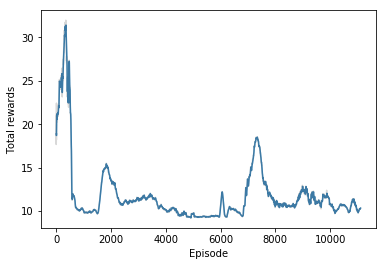

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

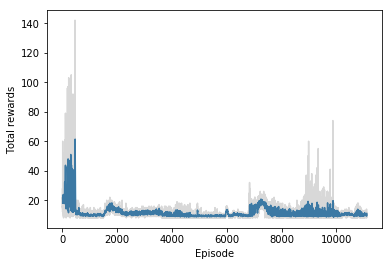

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

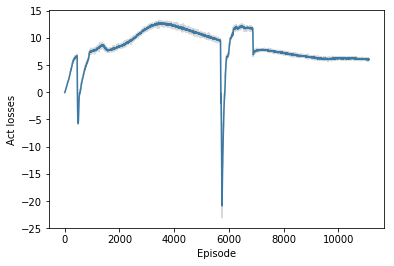

In [28]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

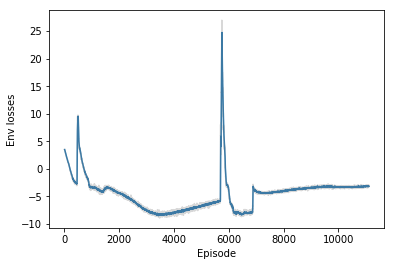

In [29]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
